<a href="https://colab.research.google.com/github/IgorNowacki/Chest-X-Ray-Images-classification---Pneumonia-detection-CNN-/blob/main/Model_RUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imprtowanie bibliotek

In [ ]:
# Obsługa danych
import numpy as np
import pandas as pd
import os

# Wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Przetwarzanie i analiza danych
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer, label_binarize

# Metryki do oceny modeli
from sklearn.metrics import auc, confusion_matrix, recall_score, precision_score, accuracy_score, f1_score, roc_auc_score, roc_curve

# Biblioteki związane z uczeniem maszynowym
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation
import keras.backend as K
from tensorflow.keras.utils import to_categorical

# Ładowanie danych

In [ ]:
#Scieżka do folderu z danymi do trenowania modelu
# Żródło: https://www.nasa.gov/collection-asset/chetan-kulkarni-and-external-partners-release-new-turbofan-engine-degradation-0
PATH="/content/drive/MyDrive/dane do modelu"

In [ ]:
#Ustawianie nazw kolumn
unit_names = ['engine_number', 'time_cycles']
settings_names = ['setting_1', 'setting_2', 'setting_3']
sensors_names = ['sensor_' + str(i + 1) for i in range(21)]
columns_names = unit_names + settings_names + sensors_names

#Ładowanie danych treningowych
FD001_train = pd.read_csv(PATH + "/train_FD001.txt",sep=" ",header=None,index_col=False, names=columns_names)
FD001_test = pd.read_csv(PATH + "/test_FD001.txt",sep=" ",header=None,index_col=False, names=columns_names)
FD001_RUL = pd.read_csv(PATH + "/RUL_FD001.txt",sep=" ",header=None,index_col=False, names=['RUL'])

print('Rozmiar danych trenigowych: ',FD001_train.shape)
print('Rozmiar danych testowych : ',FD001_test.shape)
print('Proporacja danych testowych do treningowych ',round(len(FD001_test)/(len(FD001_test)+len(FD001_train)),3))

<ipython-input-3-a7a733e6ecac>:8: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  FD001_train = pd.read_csv(PATH + "/train_FD001.txt",sep=" ",header=None,index_col=False, names=columns_names)
<ipython-input-3-a7a733e6ecac>:9: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  FD001_test = pd.read_csv(PATH + "/test_FD001.txt",sep=" ",header=None,index_col=False, names=columns_names)


Rozmiar danych trenigowych:  (20631, 26)
Rozmiar danych testowych :  (13096, 26)
Proporacja danych testowych do treningowych  0.388


In [ ]:
FD001_train.head()

,engine_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
FD001_train.loc[:,'setting_1':].describe().transpose()
# Odchylenie standardowe dla niektórych ustwień i czujników jest równe zero co może oznaczać, że wartości tych czujników są stałe w czasie

,count,mean,std,min,25%,50%,75%,max
setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
sensor_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
sensor_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
sensor_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600


 # Wstępna Obróbka danych

In [ ]:
# Funkcja dodająca infomacje o "RUL" dla każdego cyklu i silnika w zbiorze treningowym
def RUL_add(df):
    train_grouped_by = df.groupby(by='engine_number')
    max_cycle = train_grouped_by['time_cycles'].max()
    merged_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='engine_number',right_index=True)
    merged_frame["RUL"] = merged_frame["max_cycle"]-merged_frame['time_cycles']
    merged_frame = merged_frame.drop("max_cycle", axis=1)
    return merged_frame

# Stworzenie kolumny RUL w tabeli danych treningowych
FD001_train=RUL_add(FD001_train)

# Funkcja dodająca infomacje o "RUL" dla każdego cyklu i silnika w zbiorze testowym
def RUL_add_test(df, RUL_df):
  rul = pd.DataFrame(df.groupby('engine_number')['time_cycles'].max()).reset_index()
  rul.columns = ['engine_number', 'max_time_cycles']
  RUL_df.columns=["RUL"]
  RUL_df['engine_number'] = FD001_RUL.index + 1
  RUL_df['max'] = rul['max_time_cycles'] + RUL_df["RUL"]
  RUL_df.drop("RUL", axis=1, inplace=True)
  df = df.merge(RUL_df, on=['engine_number'], how='left')
  df['RUL'] = df['max'] - df['time_cycles']
  df.drop('max', axis=1, inplace=True)
  return df

# Stworzenie kolumny RUL w tabeli danych testowych
FD001_test=RUL_add_test(FD001_test, FD001_RUL)
FD001_test

,engine_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [ ]:
# Stworzenie kolumn z informacją czy silnik w zbiorze treningowym i testowym zostanie uszkodzony w przeciagu 20 i 10 cykli
threshold_1 = 10
threshold_2 = 20

# Funkcja która dodająca informacje o uszkodzeniu silnika w danym oknie czasowym
def add_threshold_columns(df, threshold_1, threshold_2):
    df['threshold_1'] = np.where(df['RUL'] <= threshold_1, 1, 0 )
    df['threshold_2'] = df['threshold_1']
    df.loc[df['RUL'] <= threshold_2, 'threshold_2'] = 2
    return df

# Stworzenie kolumn treshold_1 i treshold_2 w zbiorze treningowym i testowym
FD001_train = add_threshold_columns(FD001_train, threshold_1, threshold_2)
FD001_test = add_threshold_columns(FD001_test, threshold_1, threshold_2)
FD001_test.head()

# W zbiorze treningowym
engine_numbers_train = FD001_train[FD001_train['threshold_2'] == 2]['engine_number'].unique()
print("Numery silników z 'threshold_2' równe 2 w zbiorze treningowym: ", engine_numbers_train)

# W zbiorze testowym
engine_numbers_test = FD001_test[FD001_test['threshold_2'] == 2]['engine_number'].unique()
print("Numery silników z 'threshold_2' równe 2 w zbiorze testowym: ", engine_numbers_test)


Numery silników z 'threshold_2' równe 2 w zbiorze treningowym:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
Numery silników z 'threshold_2' równe 2 w zbiorze testowym:  [ 20  24  31  34  35  36  41  42  56  66  68  76  81  82  92 100]


In [ ]:
# Normalizacja danych MinMax  w zbiorze treningowym

FD001_train['cycle_norm'] = FD001_train['time_cycles']
cols_normalize = FD001_train.columns.difference(['engine_number','time_cycles','RUL','threshold_1','threshold_2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(FD001_train[cols_normalize]),
                             columns=cols_normalize,
                             index=FD001_train.index)
join_df = FD001_train[FD001_train.columns.difference(cols_normalize)].join(norm_train_df)
FD001_train = join_df.reindex(columns = FD001_train.columns)
FD001_train.head()

,engine_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL,threshold_1,threshold_2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [ ]:
# Normalizacja MinMax danych w zbiorze testowym

FD001_test['cycle_norm'] = FD001_test['time_cycles']
norm_test_df = pd.DataFrame(min_max_scaler.transform(FD001_test[cols_normalize]),
                            columns=cols_normalize,
                            index=FD001_test.index)
test_join_df = FD001_test[FD001_test.columns.difference(cols_normalize)].join(norm_test_df)
FD001_test = test_join_df.reindex(columns = FD001_test.columns)
FD001_test = FD001_test.reset_index(drop=True)
FD001_test.head()

,engine_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL,threshold_1,threshold_2,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0,0,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0,0,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0,0,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0,0,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0,0,0.01108


# Analiza danych

In [ ]:
# Wyświetlenie parametrów dla silnika nr.1
FD001_train[FD001_train.engine_number == 1]

,engine_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL,threshold_1,threshold_2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.000000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.002770
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.005540
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.008310
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.011080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,188,0.114943,0.750000,0.0,0.0,0.765060,0.683235,0.684166,0.0,...,0.0,0.666667,0.0,0.0,0.286822,0.089202,4,1,2,0.518006
188,1,189,0.465517,0.666667,0.0,0.0,0.894578,0.547853,0.772451,0.0,...,0.0,0.583333,0.0,0.0,0.263566,0.301712,3,1,2,0.520776
189,1,190,0.344828,0.583333,0.0,0.0,0.731928,0.614345,0.737677,0.0,...,0.0,0.833333,0.0,0.0,0.271318,0.239299,2,1,2,0.523546
190,1,191,0.500000,0.166667,0.0,0.0,0.641566,0.682799,0.734639,0.0,...,0.0,0.500000,0.0,0.0,0.240310,0.324910,1,1,2,0.526316


In [ ]:
#Sprawdzam czy występują puste rekordy w biorze treningowym -> Brak pustych rekordów w zbiorze treningowym
print('Liczba pustych rekordów w zbiorze testowym : ',FD001_train.isna().sum())

Liczba pustych rekordów w zbiorze testowym :  engine_number    0
time_cycles      0
setting_1        0
setting_2        0
setting_3        0
sensor_1         0
sensor_2         0
sensor_3         0
sensor_4         0
sensor_5         0
sensor_6         0
sensor_7         0
sensor_8         0
sensor_9         0
sensor_10        0
sensor_11        0
sensor_12        0
sensor_13        0
sensor_14        0
sensor_15        0
sensor_16        0
sensor_17        0
sensor_18        0
sensor_19        0
sensor_20        0
sensor_21        0
RUL              0
threshold_1      0
threshold_2      0
cycle_norm       0
dtype: int64


In [ ]:
#Sprawdzam czy występują puste rekordy w zbiorze testowym-> Brak pustych rekordów w zbiorze testowym
print('Liczba pustych rekordów w zbiorze testowym : ',FD001_test.isna().sum())

Liczba pustych rekordów w zbiorze testowym :  engine_number    0
time_cycles      0
setting_1        0
setting_2        0
setting_3        0
sensor_1         0
sensor_2         0
sensor_3         0
sensor_4         0
sensor_5         0
sensor_6         0
sensor_7         0
sensor_8         0
sensor_9         0
sensor_10        0
sensor_11        0
sensor_12        0
sensor_13        0
sensor_14        0
sensor_15        0
sensor_16        0
sensor_17        0
sensor_18        0
sensor_19        0
sensor_20        0
sensor_21        0
RUL              0
threshold_1      0
threshold_2      0
cycle_norm       0
dtype: int64


In [ ]:
FD001_train.loc[:,['engine_number','time_cycles']].describe()

,engine_number,time_cycles
count,20631.000000,20631.000000
mean,51.506568,108.807862
std,29.227633,68.880990
min,1.000000,1.000000
25%,26.000000,52.000000
50%,52.000000,104.000000
75%,77.000000,156.000000
max,100.000000,362.000000


In [ ]:
FD001_train.loc[:,'setting_1':].describe().transpose()
# Niektóre sensory mają wartość 0 w każdej kolumnie, może to być efekt normalizacji

,count,mean,std,min,25%,50%,75%,max
setting_1,20631.0,0.499490,0.125708,0.0,0.413793,0.500000,0.586207,1.0
setting_2,20631.0,0.501959,0.244218,0.0,0.333333,0.500000,0.750000,1.0
setting_3,20631.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
sensor_1,20631.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
sensor_2,20631.0,0.443052,0.150618,0.0,0.335843,0.430723,0.539157,1.0
sensor_3,20631.0,0.424746,0.133664,0.0,0.331807,0.415522,0.508829,1.0
sensor_4,20631.0,0.450435,0.151935,0.0,0.339467,0.435348,0.545324,1.0
sensor_5,20631.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
sensor_6,20631.0,0.980321,0.138898,0.0,1.000000,1.000000,1.000000,1.0
sensor_7,20631.0,0.566459,0.142527,0.0,0.476651,0.578100,0.669887,1.0


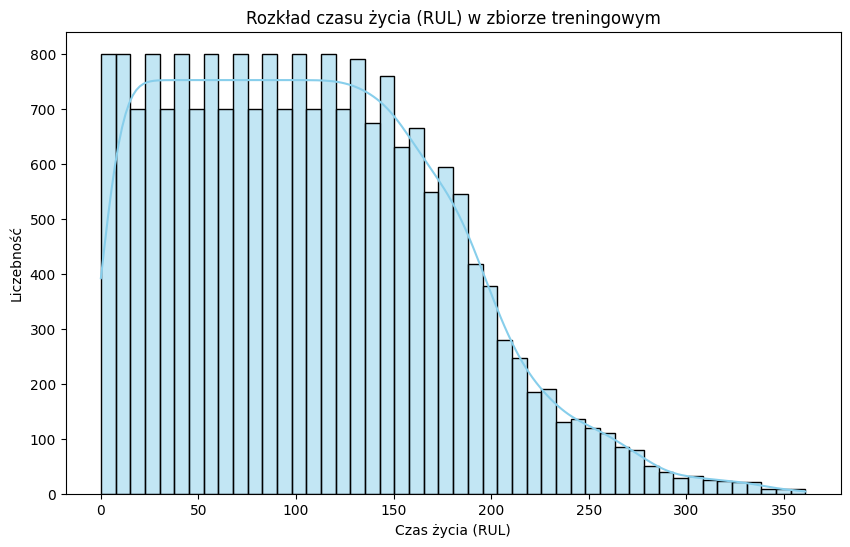

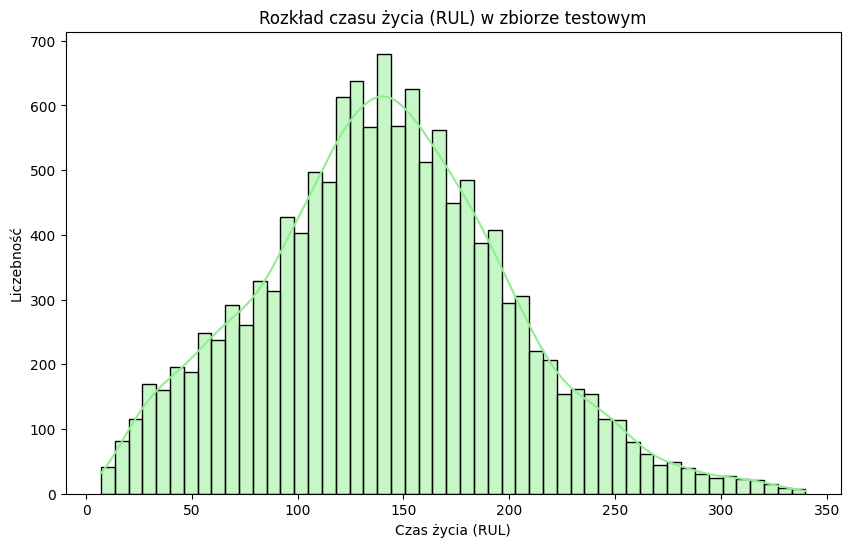

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Rozkład RUL w zbiorze treningowym
plt.figure(figsize=(10, 6))
sns.histplot(data=FD001_train, x='RUL', kde=True, color='skyblue')
plt.title('Rozkład czasu życia (RUL) w zbiorze treningowym')
plt.xlabel('Czas życia (RUL)')
plt.ylabel('Liczebność')
plt.show()

# Rozkład RUL w zbiorze testowym
plt.figure(figsize=(10, 6))
sns.histplot(data=FD001_test, x='RUL', kde=True, color='lightgreen')
plt.title('Rozkład czasu życia (RUL) w zbiorze testowym')
plt.xlabel('Czas życia (RUL)')
plt.ylabel('Liczebność')
plt.show()


In [ ]:
# Ideas


''' Analiza wartości odstających: Sprawdź, czy istnieją wartości odstające lub nietypowe obserwacje w danych, które mogą wpływać na jakość modelu. Możesz wykonać wykresy pudełkowe,
  analizę rozkładu lub zastosować inne metody wykrywania wartości odstających.'''

'''  Inżynieria cech: Przemyśl, czy możesz stworzyć nowe cechy na podstawie istniejących,
   które mogą mieć większe znaczenie dla przewidywania wartości. Na przykład, możesz dodać różnice między sensorami, sumę ustawień itp.'''

'  Inżynieria cech: Przemyśl, czy możesz stworzyć nowe cechy na podstawie istniejących,\n   które mogą mieć większe znaczenie dla przewidywania wartości. Na przykład, możesz dodać różnice między sensorami, sumę ustawień itp.'

# Wizualizacja danych

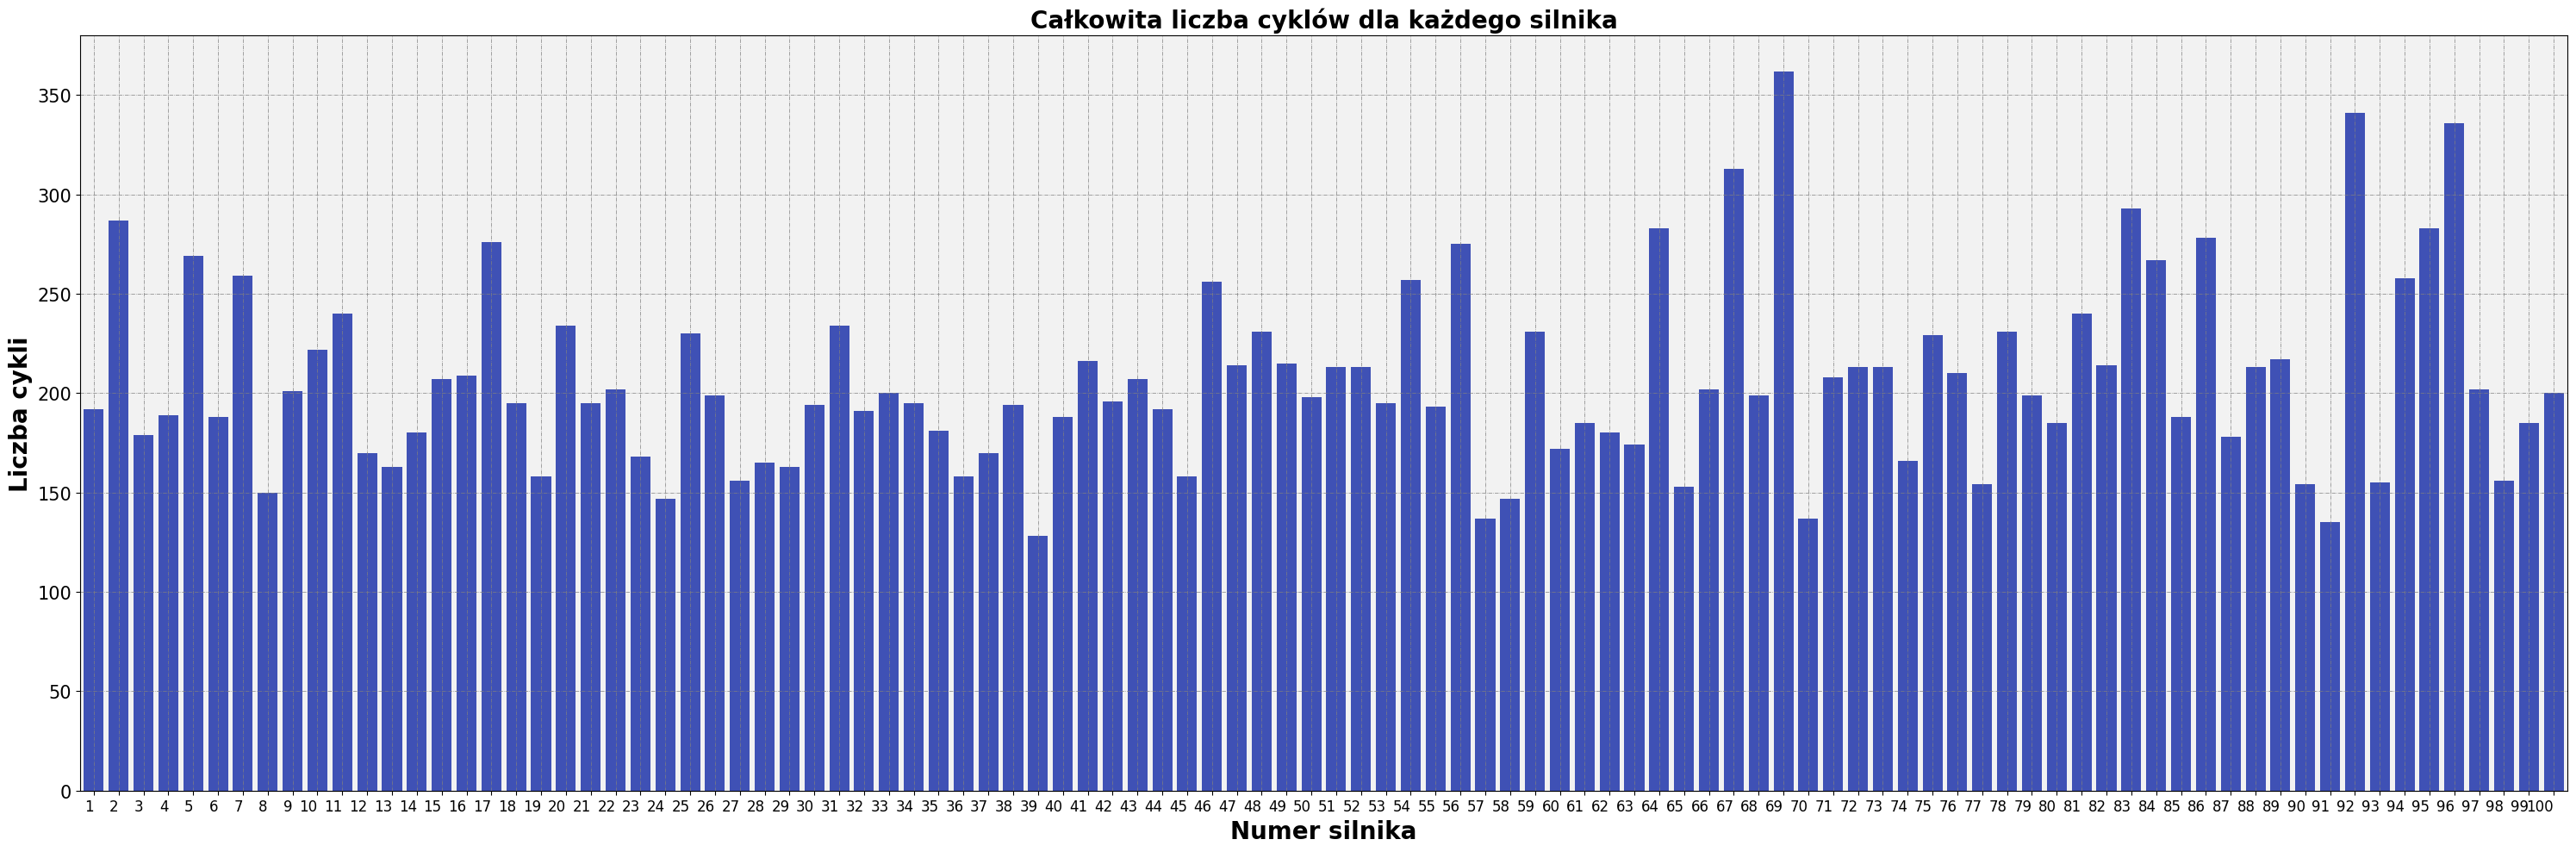

In [ ]:
# Wykres całkowitej liczby cyklów dla każdego silnika w zbiorze treningowym
max_cycle=FD001_train.groupby('engine_number').max()
plt.figure(figsize=(30,10))
ax = max_cycle['time_cycles'].plot(kind='bar', x='engine_number', y='time_cycles', width=0.6, stacked=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")
ax.set_facecolor('#f2f2f2')
ax.bar(x=max_cycle.index-1, height=max_cycle['time_cycles'], color='#3f51b5')
ax.grid(visible=True, color='gray', linestyle='-.', linewidth=0.5)
plt.title('Całkowita liczba cyklów dla każdego silnika', fontweight='bold', size=20)
plt.xlabel('Numer silnika', fontweight='bold', size=20)
plt.xticks(size=12)
plt.ylabel('Liczba cykli', fontweight='bold', size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Dystrybucja maksymalnej liczby cykli w zbiorze treningowym')

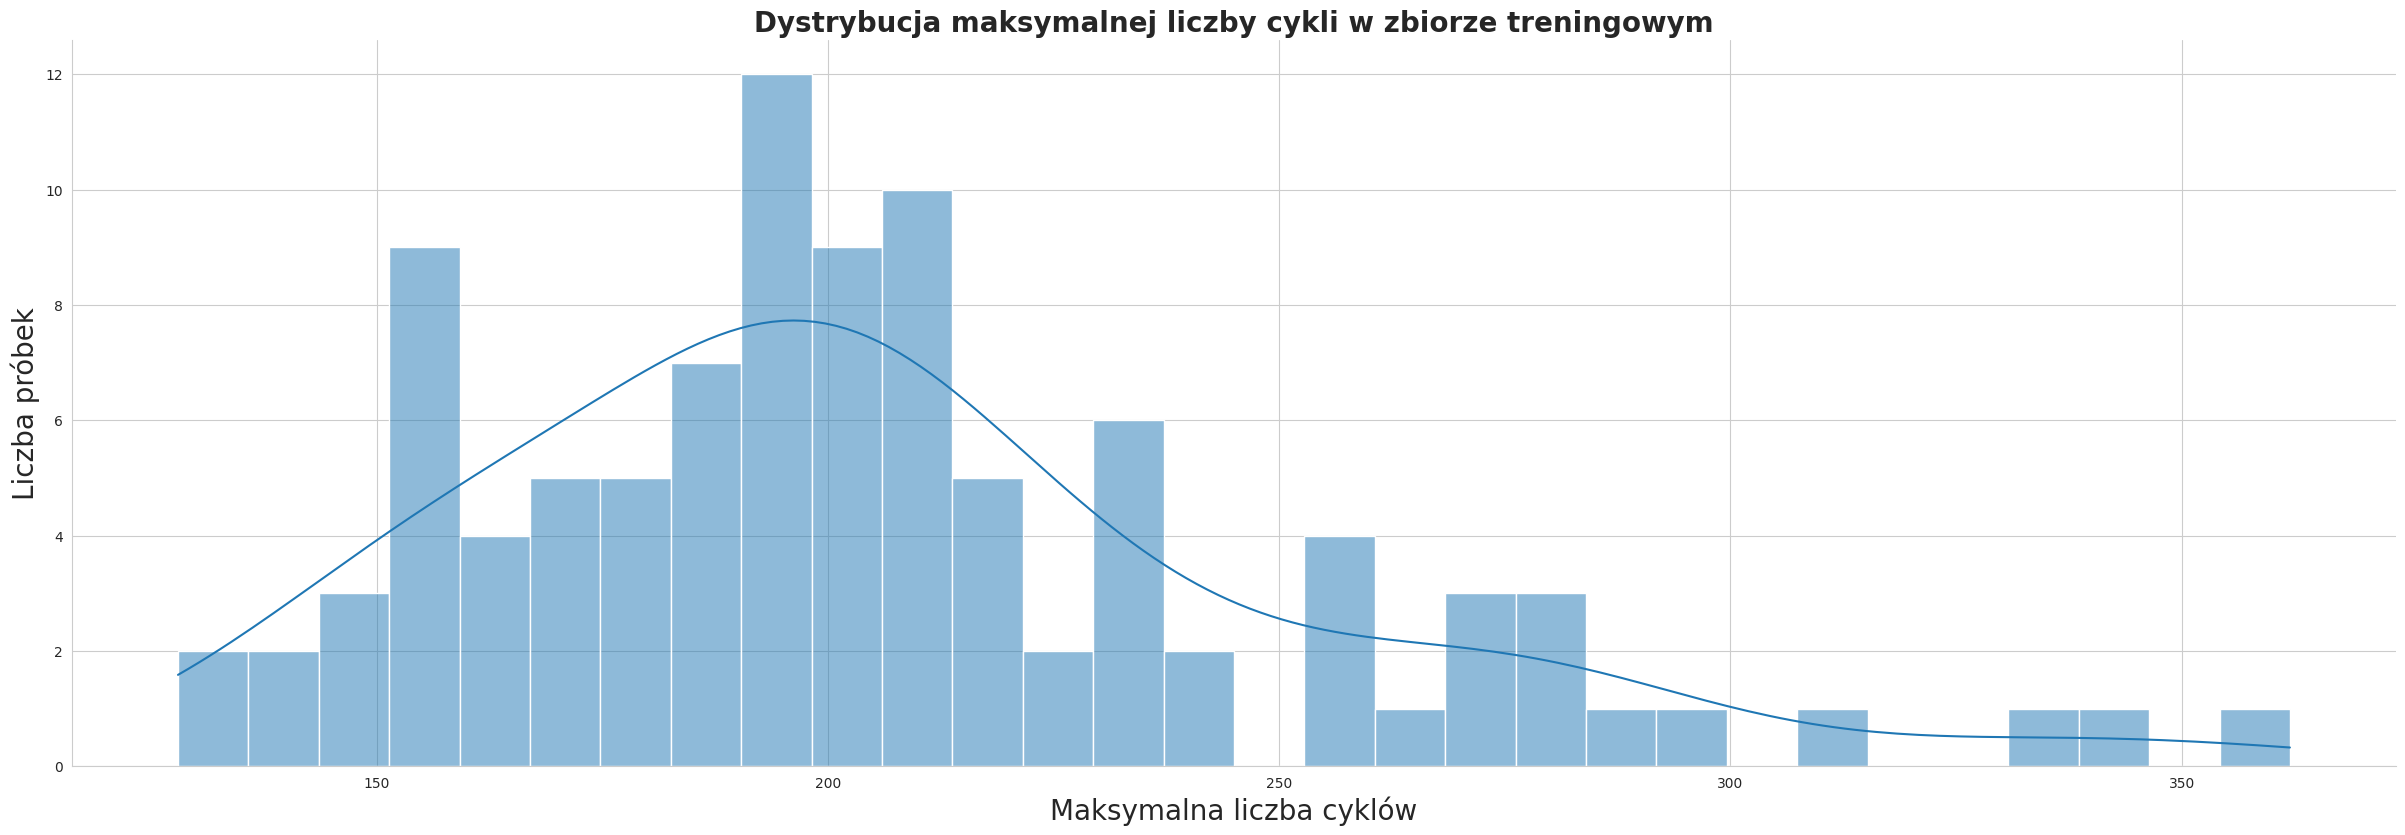

In [ ]:
# Wykres dystrybucja maksymalnej liczby cykli w zbiorze treningowym
sns.set_style("whitegrid")
sns.displot(max_cycle['time_cycles'],kde=True,bins=30,height=8,aspect=3)
plt.xlabel('Maksymalna liczba cyklów', size=20)
plt.ylabel('Liczba próbek', size=20)
plt.title('Dystrybucja maksymalnej liczby cykli w zbiorze treningowym', fontweight='bold', size=20)


Text(0.5, 1.0, 'Macierz koreacji w zbiorze treningowym')

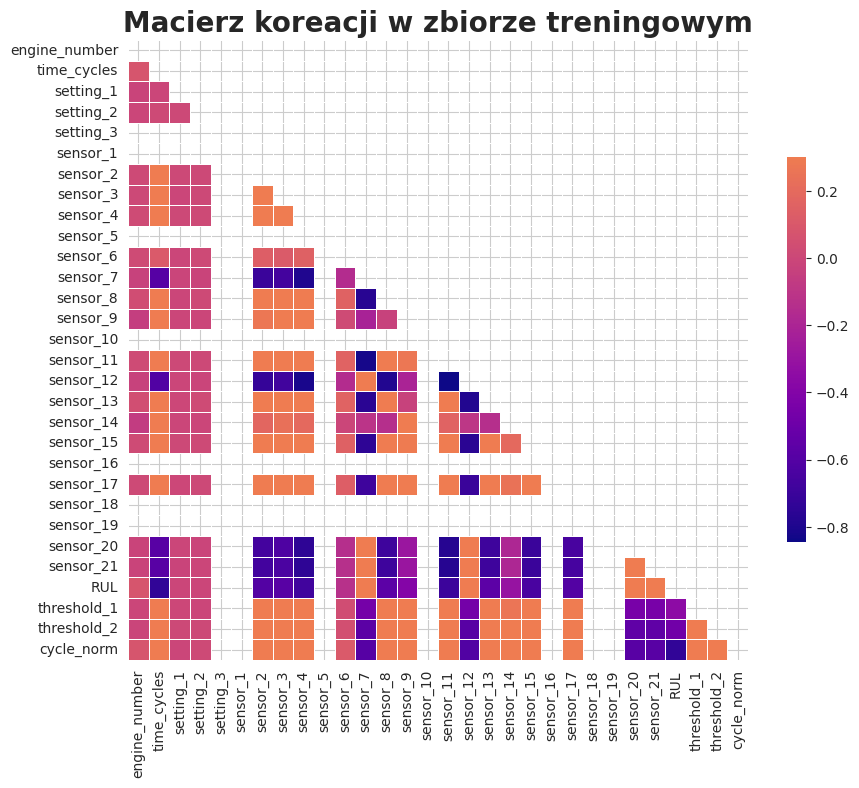

In [ ]:
# Macierz korelacji dla par zmiennych w zbiorze treningowym

# Zwrócić uwagę pry analizie na roznice pomiedzy kolaracją sensowrów RUl oraz treshold_1 i treshold_2
corr = FD001_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = 'plasma'
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Macierz koreacji w zbiorze treningowym', fontweight='bold', size=20)

# Analyzing the heatmaps, it becomes clear that some sensors have a high correlation to RUL.
# These are Sensors 7, 12, 20 and 21. Sensor 9 and Sensor 14 have a very high correlation to each other, but since none of them has a substatial correlation to the target,
 # both can be dropped together with the rest of the low-correlation features.

#None of the timeseries has outliers, this is good, however some measurements vary more in values than others. To continue, we define a list of the features we want to use, and continue with them

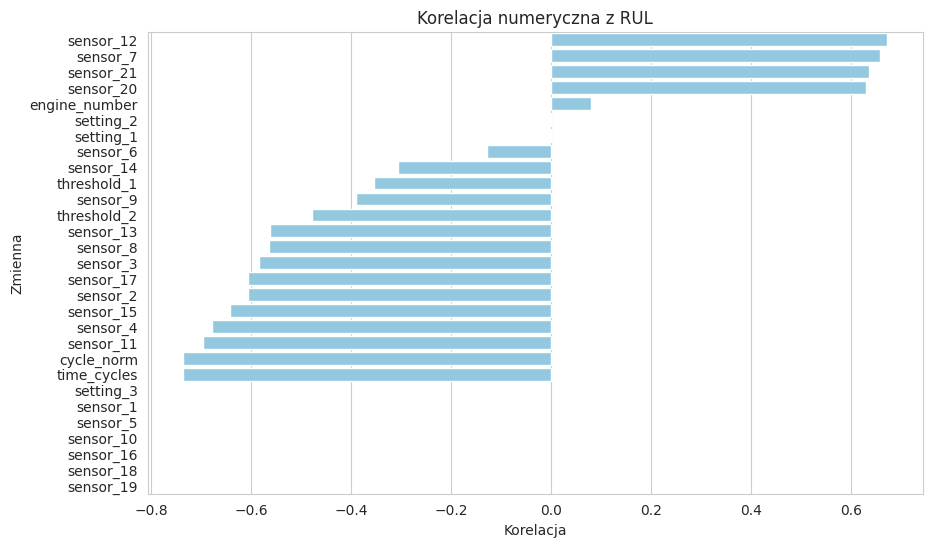

In [ ]:
# Obliczanie korelacji numerycznej
correlations = FD001_train.corr()['RUL'].drop(['RUL']).sort_values(ascending=False)

# Wykres korelacji numerycznej
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, color='skyblue')
plt.title('Korelacja numeryczna z RUL')
plt.xlabel('Korelacja')
plt.ylabel('Zmienna')
plt.show()

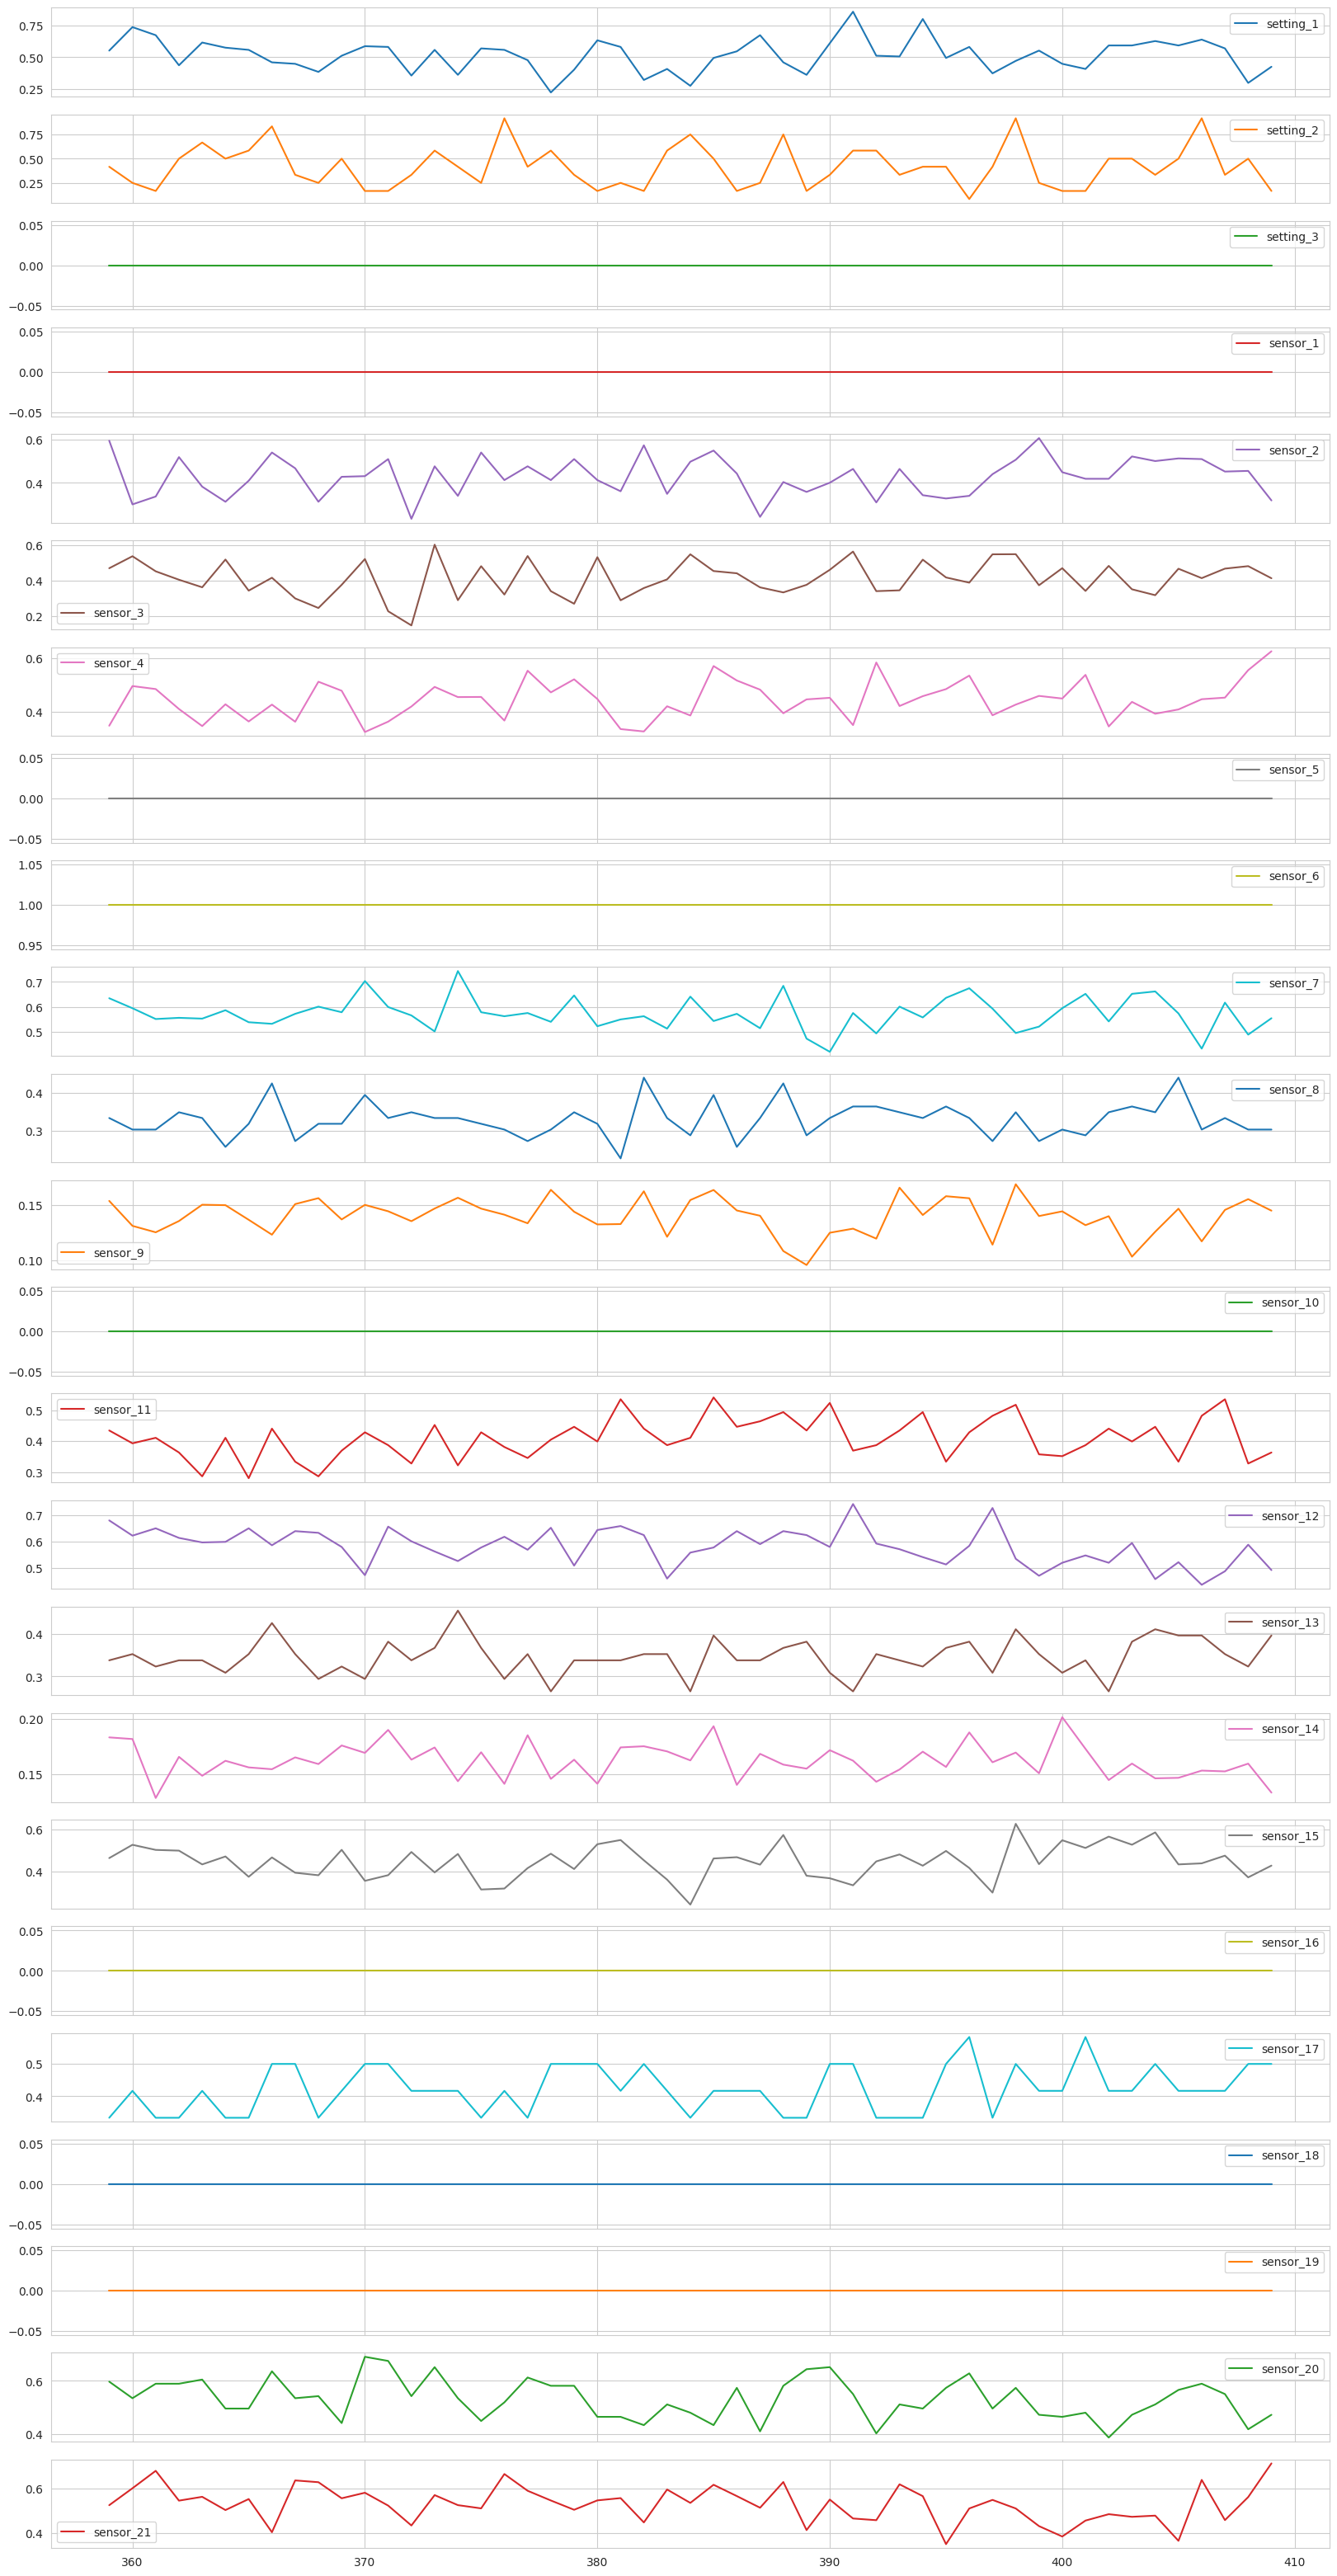

In [ ]:
# Wykresy wartości czujników i ustawień dla silnika nr. 5 w biorze testowym, dla ostatnich 50 cyklów
engine_5 = FD001_test[FD001_test['engine_number'] == 5]
engine_5_50_cycle= engine_5[engine_5['RUL'] <= engine_5['RUL'].min() + 50]
cols1 = ['setting_1','setting_2','setting_3','sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']
engine_5_50_cycle1 = engine_5_50_cycle[cols1]

ax1 = engine_5_50_cycle1.plot(subplots=True, sharex=True, figsize=(20,40))

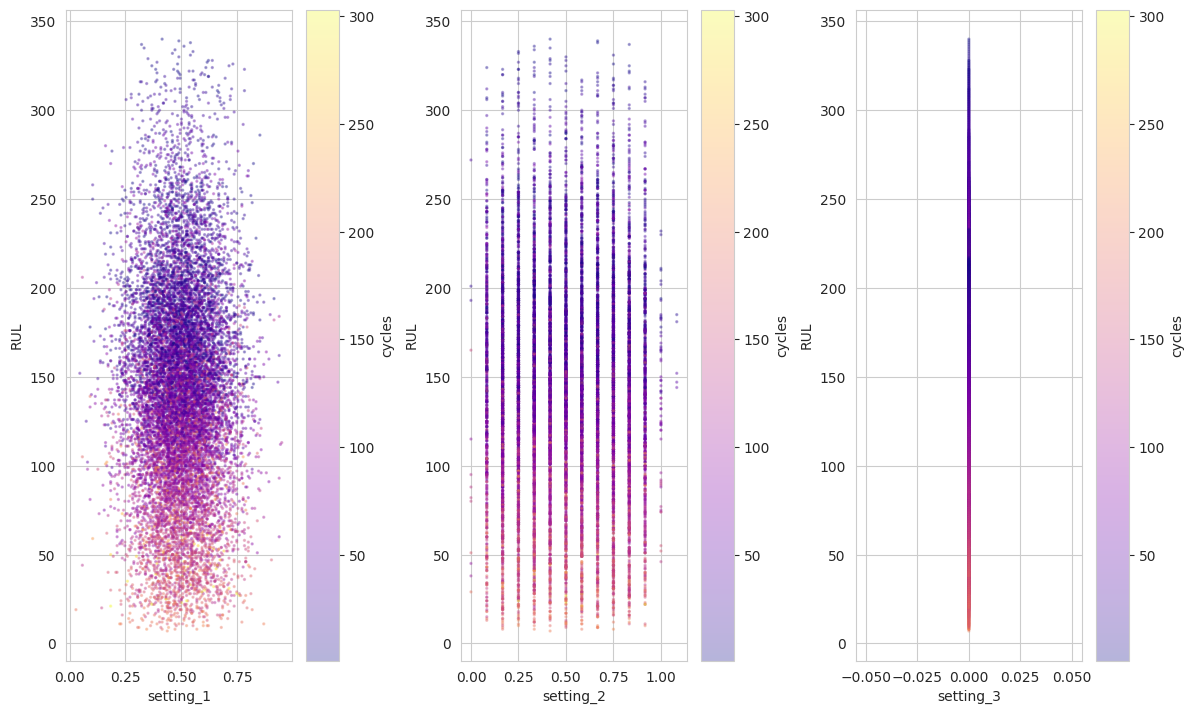

In [ ]:
# Wykresy zmian wskazań ustawień w zbiorze treningowym

for i in range(0,3):
  plt.figure(1, figsize=(12, 21))
  plt.subplot(3, 3, i+1)
  plt.scatter(
  x=FD001_test[f"setting_{i+1}"], y=FD001_test["RUL"], s=2,
  alpha=0.3, c=FD001_test["time_cycles"], cmap=plt.get_cmap("plasma"))
  plt.colorbar(label = "cycles"), plt.tight_layout()
  plt.xlabel(f"setting_{i+1}"), plt.ylabel("RUL")
  plt.grid(True)

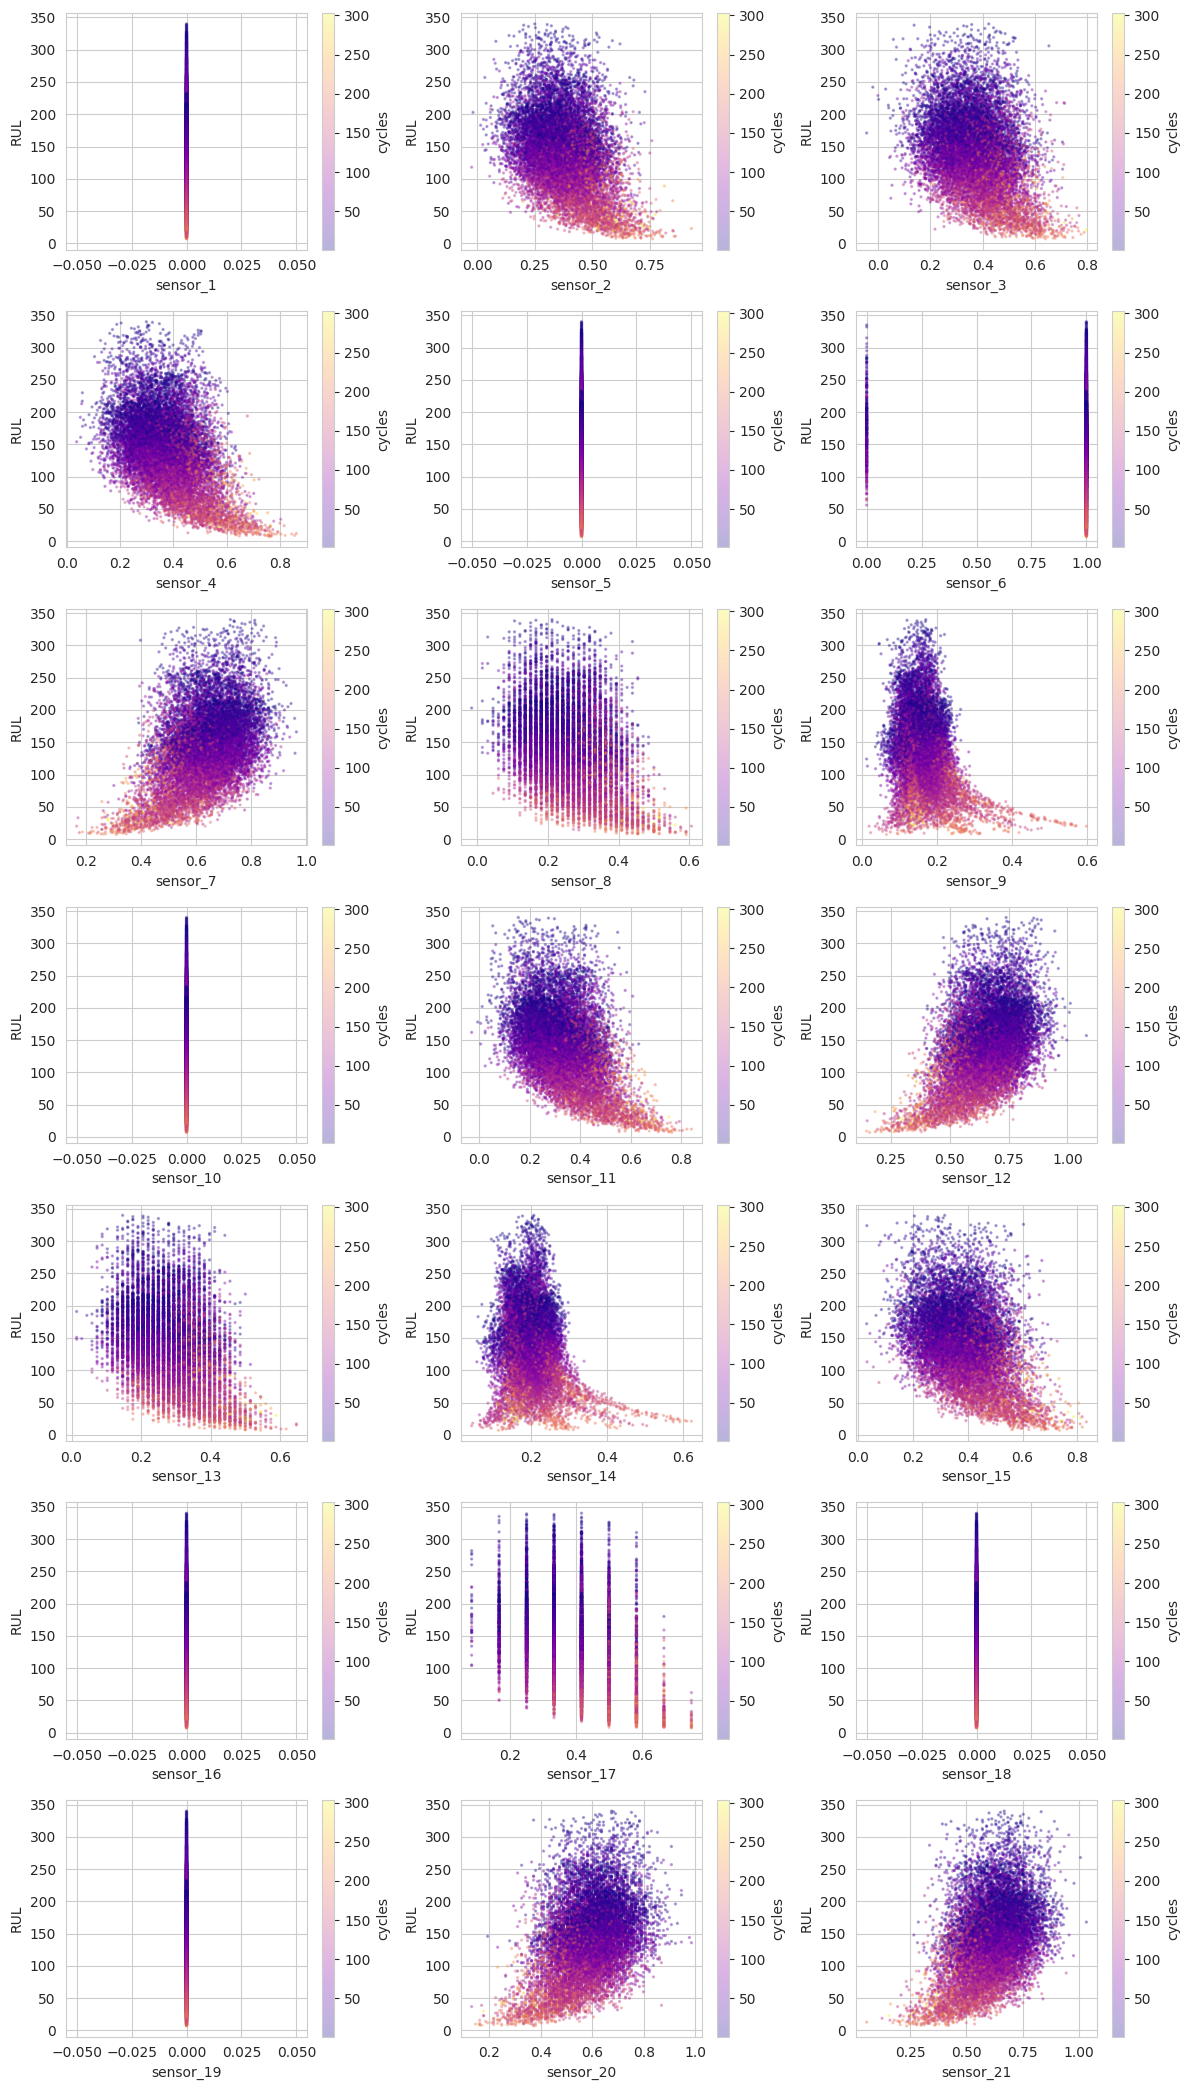

In [ ]:
# Wykresy zmian wskazań dla kazdego czujnika w zbiorze treningowym

for i in range(0,21):
  plt.figure(1, figsize=(12, 21))
  plt.subplot(22//3, 3, i+1)
  plt.scatter(
  x=FD001_test[f"sensor_{i+1}"], y=FD001_test["RUL"], s=2,
  alpha=0.3, c=FD001_test["time_cycles"], cmap=plt.get_cmap("plasma"))
  plt.colorbar(label = "cycles"), plt.tight_layout()
  plt.xlabel(f"sensor_{i+1}"), plt.ylabel("RUL")
  plt.grid(True)

# sensory 1,5, 10, 16, 18 , 19 oraz settings_3 do wyrzucenia - mają stłą wartosć we wszystkich rekordach.
# sensor 6 przyjmuje dwie wartość 21,60 i 21,61 - też może być mało pomocny przy obliczaniu RUL
# Odchylenie standardowe powyżzych czujnikó jest rózne zero, widoczne jest to także na powyższych wykresach.

#Good training depends on the use of feautures that has high corelation to the target.
#A perfect line from bottom left to top right in the previous plots would suggest a correlation of 1.
# The sensors that resembles this may have the most correlation to the target RUL. To aid in this determination, we can also calculate corelations numerically.

# Przygotowanie danych

In [ ]:
# Usuwanie kolumn ze wskazaniami sensora nr 1, 5, 10, 16, 18, 19 oraz setting_3 - na podstawie powyższej analizy danych.

colums_to_drop=['setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']

FD001_train = FD001_train.drop(colums_to_drop, axis =1)
FD001_test = FD001_test.drop(colums_to_drop, axis =1)

In [ ]:
print("*" * 50)
print('Maksymalna ilość cykli dla silników w zbiorze treningowym')
train_max_cycles = FD001_train.groupby('engine_number')['time_cycles'].max().describe().reset_index()
train_max_cycles.columns = ['Statystyka', 'Wartość']
print(train_max_cycles.to_string(index=False))

print("*" * 50)
print('Maksymalna ilość cykli dla silników w zbiorze testowym')
test_max_cycles = FD001_test.groupby('engine_number')['time_cycles'].max().describe().reset_index()
test_max_cycles.columns = ['Statystyka', 'Wartość']
print(test_max_cycles.to_string(index=False))

print("*" * 50)

**************************************************
Maksymalna ilość cykli dla silników w zbiorze treningowym
Statystyka    Wartość
     count 100.000000
      mean 206.310000
       std  46.342749
       min 128.000000
       25% 177.000000
       50% 199.000000
       75% 229.250000
       max 362.000000
**************************************************
Maksymalna ilość cykli dla silników w zbiorze testowym
Statystyka    Wartość
     count 100.000000
      mean 130.960000
       std  53.593479
       min  31.000000
       25%  88.750000
       50% 133.500000
       75% 164.250000
       max 303.000000
**************************************************


# Model LSTM klasyfikacja binarna - threshold_1 (uszkodenie w ciągu 20 cykli)

In [ ]:
# Ścieżka do zapisania modelu LSTM_model_1
model_threshold_1_path = '/content/drive/MyDrive/RUL_model/binary_model_threshold_1.h5'

In [ ]:
#LSTM Model
print('*********************************************************************************************************************************************flag')
# żrodło: https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb
# żrodło: https://github.com/umbertogriffo/Predictive-Maintenance-using-LSTM/blob/master/src/lstm/binary_classification.py
# Warstwy LSTM w bibliotece Keras oczekują wejścia w postaci tablicy numpy o 3 wymiarach (samples, time steps, features),
# gdzie samples to liczba sekwencji treningowych, time steps to okno wsteczne lub długość sekwencji,
# a features to liczba cech każdej sekwencji w każdym kroku czasowym.

# Ustawiam oko wsteczne sekwencji
sequence_size = 50

# Funkcja do przekształcania cech (samples, time steps, features)
def sequence_generator(engine_df, seq_size, seq_variable):
    # Tylko sekwencje o zdefiniownajej długości okna są brane pod uwagę, nie stosuje się żadnego dopełniania.
    # Oznacza to, że podczas testowania musimy odrzucić te, które są krótsze niż długość okna. Alternatywą mogłoby być dopełnienie sekwencji, abyśmy mogli używać krótszych.
    variable_array = engine_df[seq_variable].values
    elements_number = variable_array.shape[0]
    for start, stop in zip(range(0, elements_number-seq_size), range(seq_size, elements_number)):
        yield variable_array[start:stop, :]

# Określanie kolumn do wytworzenia sekwencji
sensors_names = ['sensor_2','sensor_3','sensor_4','sensor_6','sensor_7','sensor_8','sensor_9','sensor_11','sensor_12','sensor_13','sensor_14','sensor_15','sensor_17','sensor_20','sensor_21']
sequence_variable = ['setting_1', 'setting_2', 'cycle_norm']
sequence_variable.extend(sensors_names)

# Generowanie sekwencji i konwersja do numpy array
sequence_data= (list(sequence_generator(FD001_train[FD001_train['engine_number']==id], sequence_size, sequence_variable))
           for id in FD001_train['engine_number'].unique())
sequence_array = np.concatenate(list(sequence_data)).astype(np.float32)
print('Rozmiar squence_array: ',sequence_array.shape)

# Funkcja generująca etykiety dla sekwencji
def labels_generator(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

# Funkcja generująca labels_array_treshold_1
def generate_labels(dataset, sequence_size, threshold):
    label_data = [labels_generator(dataset[dataset['engine_number']==id], sequence_size, [threshold])
                  for id in dataset['engine_number'].unique()]
    labels_array = np.concatenate(label_data).astype(np.float32)
    print(f'Rozmiar labels_array dla {threshold}: ', labels_array.shape)
    return labels_array

# Wywołanie funkcji dla threshold_1
labels_array_threshold_1 = generate_labels(FD001_train, sequence_size, "threshold_1")

features_number = sequence_array.shape[2]
output_number = labels_array_threshold_1 .shape[1]

*********************************************************************************************************************************************flag
Rozmiar squence_array:  (15631, 50, 18)
Rozmiar labels_array dla threshold_1:  (15631, 1)


In [ ]:
# 2. Budowa modelu LSTM

LSTM_model_1 = Sequential()

LSTM_model_1.add(LSTM(
         input_shape=(sequence_size, features_number),
         units=100,
         return_sequences=True))
LSTM_model_1.add(Dropout(0.2))

LSTM_model_1.add(LSTM(
          units=50,
          return_sequences=False))
LSTM_model_1.add(Dropout(0.2))

LSTM_model_1.add(Dense(units=output_number, activation='sigmoid'))
LSTM_model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(LSTM_model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           47600     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 77,851
Trainable params: 77,851
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# 3. Trening mogelu LSTM_model_1
LSTM_model_1_history = LSTM_model_1.fit(sequence_array, labels_array_threshold_1, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_threshold_1_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
75/75 - 12s - loss: 0.1937 - accuracy: 0.9370 - val_loss: 0.1103 - val_accuracy: 0.9540 - 12s/epoch - 165ms/step
Epoch 2/100
75/75 - 1s - loss: 0.0695 - accuracy: 0.9725 - val_loss: 0.0705 - val_accuracy: 0.9706 - 642ms/epoch - 9ms/step
Epoch 3/100
75/75 - 1s - loss: 0.0553 - accuracy: 0.9777 - val_loss: 0.0387 - val_accuracy: 0.9859 - 657ms/epoch - 9ms/step
Epoch 4/100
75/75 - 1s - loss: 0.0495 - accuracy: 0.9786 - val_loss: 0.0367 - val_accuracy: 0.9898 - 645ms/epoch - 9ms/step
Epoch 5/100
75/75 - 1s - loss: 0.0386 - accuracy: 0.9838 - val_loss: 0.0405 - val_accuracy: 0.9808 - 627ms/epoch - 8ms/step
Epoch 6/100
75/75 - 1s - loss: 0.0352 - accuracy: 0.9855 - val_loss: 0.0324 - val_accuracy: 0.9872 - 853ms/epoch - 11ms/step
Epoch 7/100
75/75 - 1s - loss: 0.0350 - accuracy: 0.9856 - val_loss: 0.0315 - val_accuracy: 0.9847 - 879ms/epoch - 12ms/step
Epoch 8/100
75/75 - 1s - loss: 0.0347 - accuracy: 0.9852 - val_loss: 0.0285 - val_accuracy: 0.9898 - 900ms/epoch - 12ms/step
Epoc

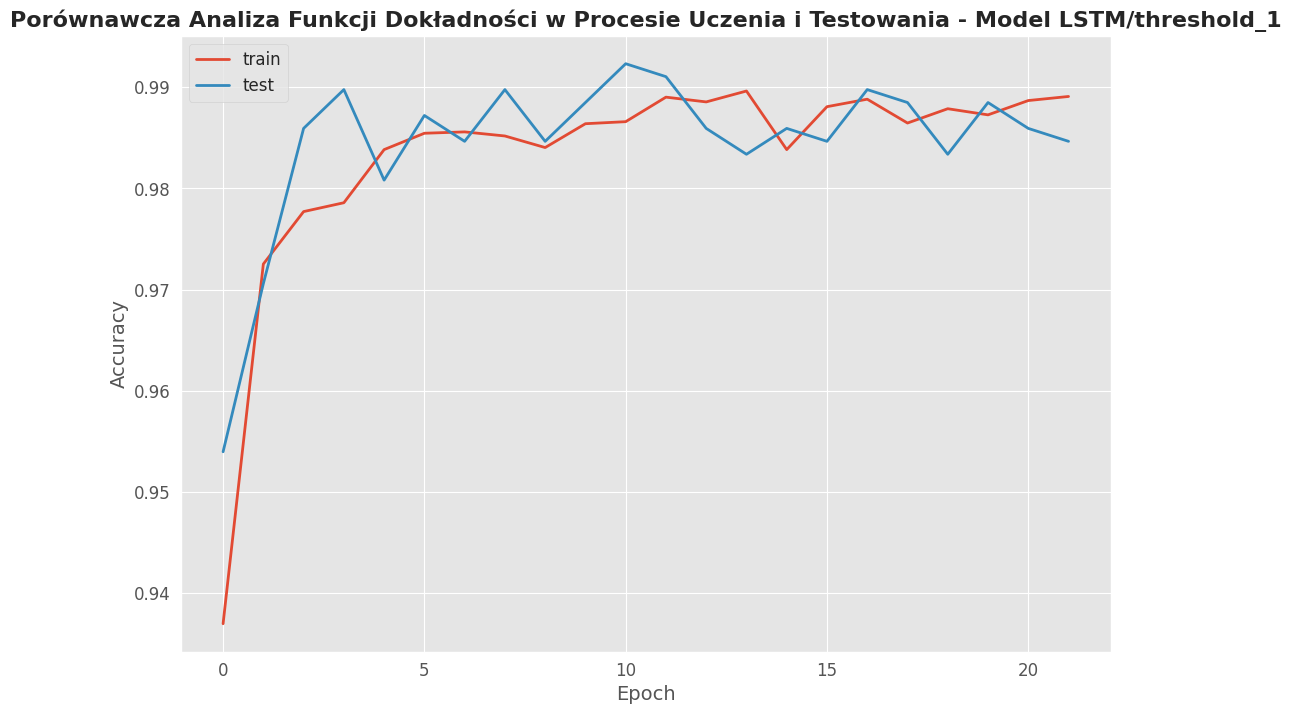

In [ ]:
# 4. Ewaluacja modelu na danych treningowych

# Porównawcza Analiza Funkcji Dokładności w Procesie Uczenia i Testowania
plt.style.use('ggplot')
fig_acc, ax = plt.subplots(figsize=(12, 8))
ax.plot(LSTM_model_1_history.history['accuracy'], label='train', linewidth=2)
ax.plot(LSTM_model_1_history.history['val_accuracy'], label='test', linewidth=2)
ax.set_title('Porównawcza Analiza Funkcji Dokładności w Procesie Uczenia i Testowania - Model LSTM/threshold_1', fontsize=16, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='upper left', fontsize=12)
ax.grid(True)
plt.show()
fig_acc.savefig("/content/drive/MyDrive/RUL_model/LSTM_model_1_history_accuracy.png")

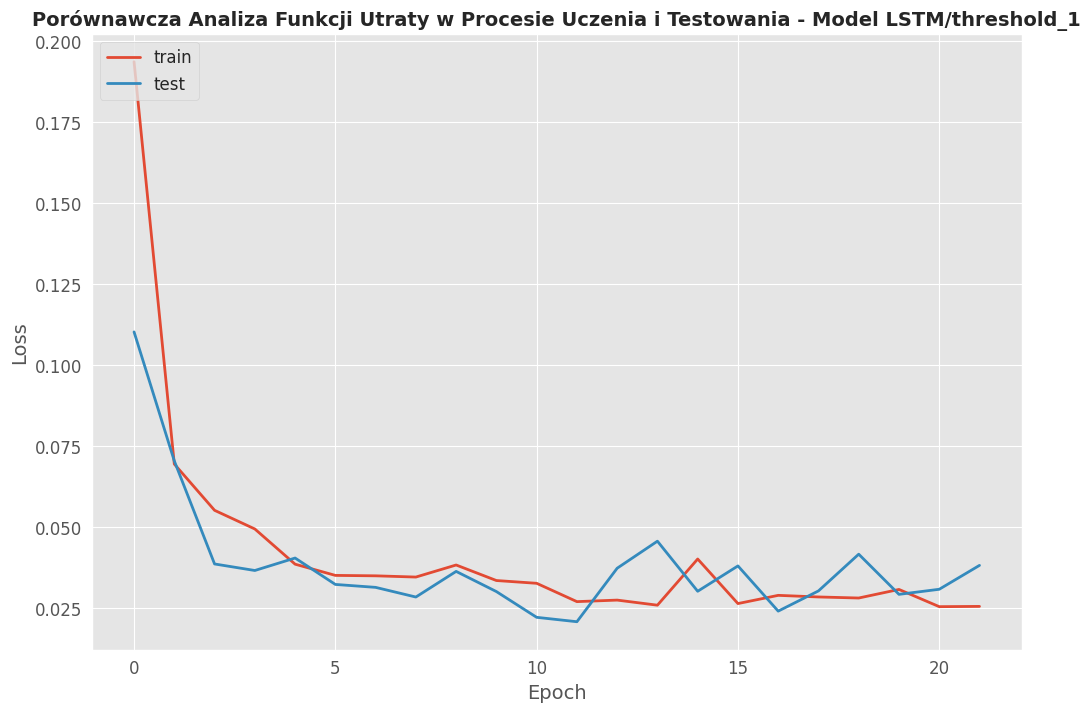

In [ ]:
# Porównawcza Analiza Funkcji Utraty w Procesie Uczenia i Testowania
plt.style.use('ggplot')
fig_loss, ax = plt.subplots(figsize=(12, 8))
ax.plot(LSTM_model_1_history.history['loss'], label='train', linewidth=2)
ax.plot(LSTM_model_1_history.history['val_loss'], label='test', linewidth=2)
ax.set_title('Porównawcza Analiza Funkcji Utraty w Procesie Uczenia i Testowania - Model LSTM/threshold_1', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='upper left', fontsize=12)
ax.grid(True)
plt.show()
fig_loss.savefig("/content/drive/MyDrive/RUL_model/LSTM_model_1_history_loss.png")


In [ ]:
# make predictions
LSTM_model_1_y_pred = (LSTM_model_1.predict(sequence_array,verbose=1, batch_size=200) > 0.5).astype("int32")
LSTM_model_1_y_true = labels_array_threshold_1

79/79 [==============================] - 1s 5ms/step


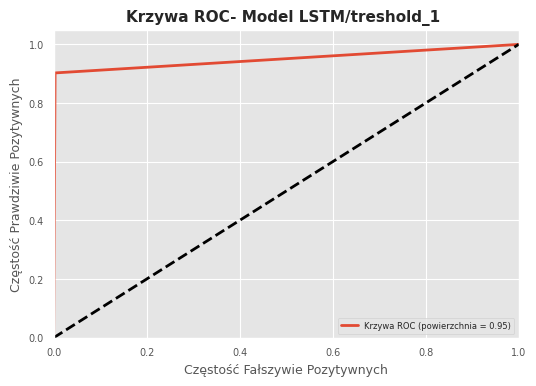

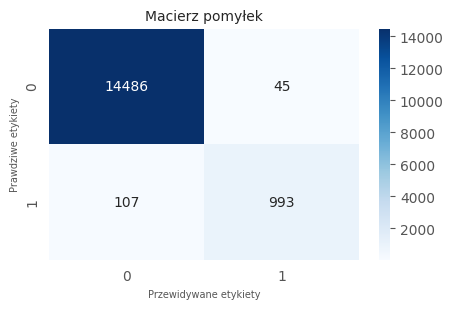

,Metric,Value
0,Accuracy,0.990276
1,Precision,0.956647
2,Recall,0.902727
3,F1 Score,0.928906
4,AUC ROC,0.949815


In [ ]:
# Obliczenie metryk
accuracy = accuracy_score(LSTM_model_1_y_true, LSTM_model_1_y_pred)
precision = precision_score(LSTM_model_1_y_true, LSTM_model_1_y_pred)
recall = recall_score(LSTM_model_1_y_true, LSTM_model_1_y_pred)
f1 = f1_score(LSTM_model_1_y_true, LSTM_model_1_y_pred)
auc_roc = roc_auc_score(LSTM_model_1_y_true, LSTM_model_1_y_pred)

# Utworzenie DataFrame
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC ROC'],
    'Value': [accuracy, precision, recall, f1, auc_roc]
})


# Krzywa ROC
plt.style.use('ggplot')
fpr, tpr, thresholds = roc_curve(LSTM_model_1_y_true, LSTM_model_1_y_pred)
fig_roc, ax = plt.subplots(figsize=(6, 4))
ax.plot(fpr, tpr, label='Krzywa ROC (powierzchnia = %0.2f)' % auc_roc, linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', linewidth=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Częstość Fałszywie Pozytywnych', fontsize=9)
ax.set_ylabel('Częstość Prawdziwie Pozytywnych', fontsize=9)
ax.set_title('Krzywa ROC- Model LSTM/treshold_1 ', fontsize=11, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.legend(loc="lower right", fontsize=6)
ax.grid(True)
plt.show()

# Obliczanie macierzy pomyłek
cm = confusion_matrix(LSTM_model_1_y_true, LSTM_model_1_y_pred)
plt.figure(figsize=(5, 3))

# Utworzenie heatmapy za pomocą seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Macierz pomyłek', fontsize=10)
plt.ylabel('Prawdziwe etykiety', fontsize=7)
plt.xlabel('Przewidywane etykiety', fontsize=7)
plt.show()
metrics

In [ ]:
# 4. Ewaluacja modelu na danych treningowych

sequence_data_test = [FD001_test[FD001_test['engine_number']==id][sequence_variable].values[-sequence_size:]
                       for id in FD001_test['engine_number'].unique() if len(FD001_test[FD001_test['engine_number']==id]) >= sequence_size]
sequence_array_test = np.asarray(sequence_data_test).astype(np.float32)

In [ ]:
# Pobierania etykiet sekwencji, które mają co najmniej 50 elementów
more_50 = [len(FD001_test[FD001_test['engine_number']==id]) >= sequence_size for id in FD001_test['engine_number'].unique()]
label_array_test_treshold_1 = FD001_test.groupby('engine_number')['threshold_1'].nth(-1)[more_50].values
label_array_test_treshold_1 = label_array_test_treshold_1.reshape(label_array_test_treshold_1.shape[0],1).astype(np.float32)
print(sequence_array_test.shape)
print(label_array_test_treshold_1.shape)

(93, 50, 18)
(93, 1)


In [ ]:
if os.path.isfile(model_threshold_1_path):
    estimator_treshhold_1 = load_model(model_threshold_1_path)

In [ ]:
scores_test = estimator_treshhold_1.evaluate(sequence_array_test, label_array_test_treshold_1, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 1s - loss: 0.0349 - accuracy: 0.9892 - 721ms/epoch - 240ms/step
Accurracy: 0.9892473220825195


In [ ]:
# make predictions
LSTM_model_1_y_pred = (LSTM_model_1.predict(sequence_array_test,verbose=1, batch_size=200) > 0.5).astype("int32")
LSTM_model_1_y_true = label_array_test_treshold_1

1/1 [==============================] - 0s 22ms/step


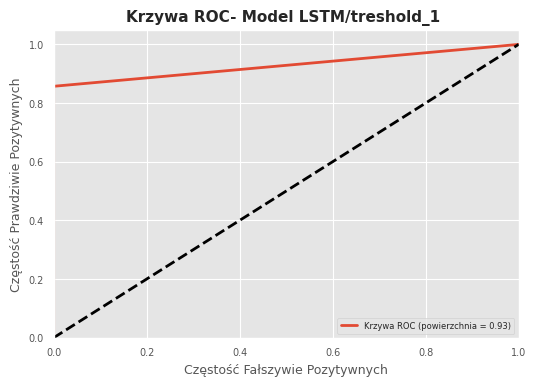

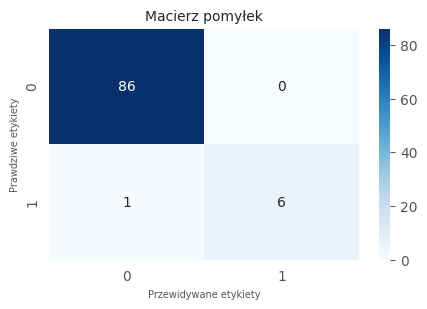

,Metric,Value
0,Accuracy,0.989247
1,Precision,1.000000
2,Recall,0.857143
3,F1 Score,0.923077
4,AUC ROC,0.928571


In [ ]:
# Obliczenie metryk
accuracy = accuracy_score(LSTM_model_1_y_true, LSTM_model_1_y_pred)
precision = precision_score(LSTM_model_1_y_true, LSTM_model_1_y_pred)
recall = recall_score(LSTM_model_1_y_true, LSTM_model_1_y_pred)
f1 = f1_score(LSTM_model_1_y_true, LSTM_model_1_y_pred)
auc_roc = roc_auc_score(LSTM_model_1_y_true, LSTM_model_1_y_pred)

# Utworzenie DataFrame
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC ROC'],
    'Value': [accuracy, precision, recall, f1, auc_roc]
})

# Krzywa ROC
plt.style.use('ggplot')
fpr, tpr, thresholds = roc_curve(LSTM_model_1_y_true, LSTM_model_1_y_pred)
fig_roc, ax = plt.subplots(figsize=(6, 4))
ax.plot(fpr, tpr, label='Krzywa ROC (powierzchnia = %0.2f)' % auc_roc, linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', linewidth=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Częstość Fałszywie Pozytywnych', fontsize=9)
ax.set_ylabel('Częstość Prawdziwie Pozytywnych', fontsize=9)
ax.set_title('Krzywa ROC- Model LSTM/treshold_1 ', fontsize=11, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.legend(loc="lower right", fontsize=6)
ax.grid(True)
plt.show()

# Obliczanie macierzy pomyłek
cm = confusion_matrix(LSTM_model_1_y_true, LSTM_model_1_y_pred)
plt.figure(figsize=(5, 3))

# Utworzenie heatmapy za pomocą seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Macierz pomyłek', fontsize=10)
plt.ylabel('Prawdziwe etykiety', fontsize=7)
plt.xlabel('Przewidywane etykiety', fontsize=7)
plt.show()
metrics

In [ ]:
LSTM_model_1_y_true.shape
print(LSTM_model_1_y_true[42])
print(LSTM_model_1_y_pred[4])

[0.]
[0]


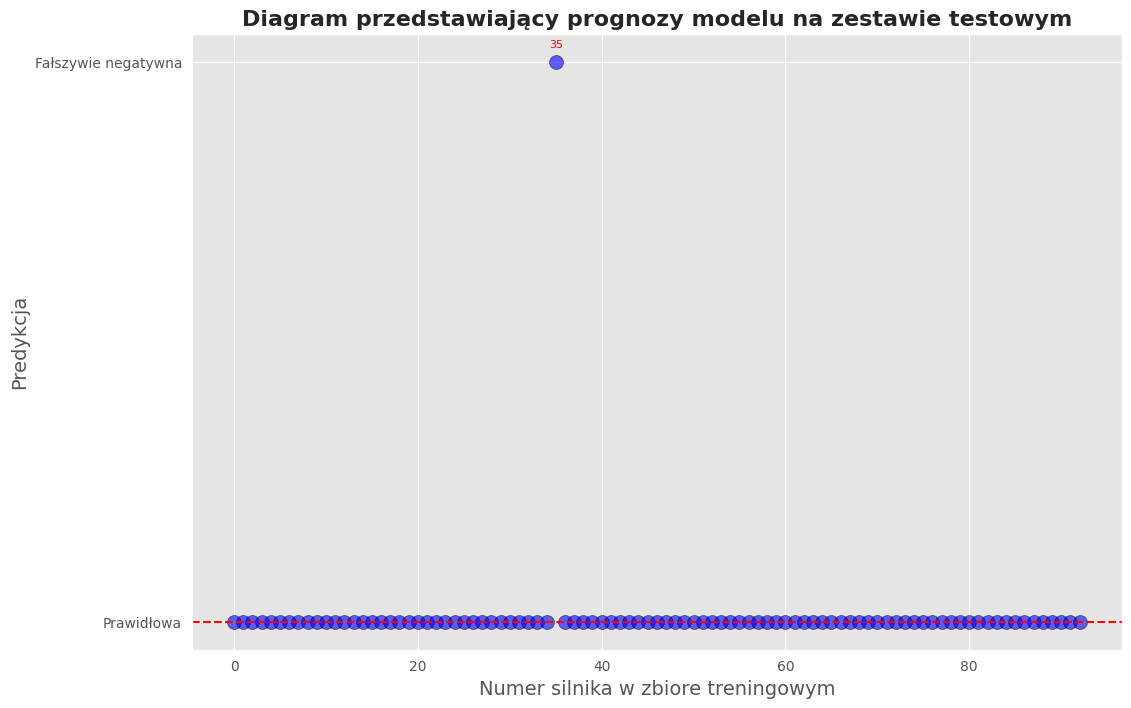

In [ ]:
# Rysowanie wykresu Diagram przedstawiający prognozy modelu na zestawie testowym - ##################- nazwa do zmiany
plt.style.use('ggplot')

residuals = LSTM_model_1_y_true - LSTM_model_1_y_pred

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(range(len(residuals)), residuals, color="blue", edgecolors='k', s=100, alpha=0.6)
ax.axhline(0, color='r', linestyle='--')  # dodajemy linię oznaczającą zero

ax.set_title('Diagram przedstawiający prognozy modelu na zestawie testowym', fontsize=16, fontweight='bold')
ax.set_xlabel('Numer silnika w zbiore treningowym', fontsize=14)
ax.set_ylabel('Predykcja', fontsize=14)

# Definiujemy lokalizacje dla etykiet
ax.yaxis.set_major_locator(ticker.FixedLocator([-1, 0, 1]))

# Zmieniamy etykiety na osi y
ax.yaxis.set_major_formatter(ticker.FixedFormatter(['Fałszywie pozytywna', 'Prawidłowa', 'Fałszywie negatywna']))

# Dodajemy etykiety do punktów danych
for i, val in enumerate(residuals):
    if val != 0:  # jeżeli residuum nie leży na osi X
        ax.annotate(i, (i, val), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color="red")

plt.show()

#Model LSTM klasyfikacja binarna - treshold_2 (uszkodenie w ciągu 10 cykli)

In [ ]:
# Ścieżka do zapisania LSTM_model_2
model_threshold_2_path = '/content/drive/MyDrive/RUL_model/binary_model_treshhold_2.h5'

In [ ]:
# Generowanie etykiet dla sekwencji przy threshold_2
def generate_labels(dataset, sequence_size, threshold):
    label_data = [labels_generator(dataset[dataset['engine_number']==id], sequence_size, [threshold])
                  for id in dataset['engine_number'].unique()]
    labels_array = np.concatenate(label_data).astype(np.float32)
    labels_array = to_categorical(labels_array)
    print(f'Rozmiar labels_array dla {threshold}: ', labels_array.shape)
    return labels_array

# Wywołanie funkcji dla threshold_1
labels_array_threshold_1 = generate_labels(FD001_train, sequence_size, "threshold_1")

# Wywołanie funkcji dla threshold_2
labels_array_threshold_2 = generate_labels(FD001_train, sequence_size, "threshold_2")
labels_array_threshold_2

Rozmiar labels_array dla threshold_1:  (15631, 2)
Rozmiar labels_array dla threshold_2:  (15631, 3)


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
# 2. Budowa modelu LSTM
features_number = sequence_array.shape[2]
output_number = labels_array_threshold_2.shape[1]

LSTM_model_2 = Sequential()

LSTM_model_2.add(LSTM(
         input_shape=(sequence_size, features_number),
         units=100,
         return_sequences=True))
LSTM_model_2.add(Dropout(0.2))

LSTM_model_2.add(LSTM(
          units=50,
          return_sequences=False))
LSTM_model_2.add(Dropout(0.2))

LSTM_model_2.add(Dense(units=output_number, activation='softmax'))
LSTM_model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(LSTM_model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 100)           47600     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 77,953
Trainable params: 77,953
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#3 Trening mogelu LSTM_model_2
LSTM_model_2_history = LSTM_model_2.fit(sequence_array, labels_array_threshold_2, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=2, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_threshold_2_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
75/75 - 7s - loss: 0.2450 - accuracy: 0.9125 - val_loss: 0.0979 - val_accuracy: 0.9668 - 7s/epoch - 94ms/step
Epoch 2/100
75/75 - 1s - loss: 0.0878 - accuracy: 0.9630 - val_loss: 0.0815 - val_accuracy: 0.9604 - 654ms/epoch - 9ms/step
Epoch 3/100
75/75 - 1s - loss: 0.0666 - accuracy: 0.9738 - val_loss: 0.0576 - val_accuracy: 0.9757 - 639ms/epoch - 9ms/step
Epoch 4/100
75/75 - 1s - loss: 0.0575 - accuracy: 0.9756 - val_loss: 0.0920 - val_accuracy: 0.9655 - 607ms/epoch - 8ms/step
Epoch 5/100
75/75 - 1s - loss: 0.0546 - accuracy: 0.9784 - val_loss: 0.0824 - val_accuracy: 0.9616 - 595ms/epoch - 8ms/step
Epoch 6/100
75/75 - 1s - loss: 0.0553 - accuracy: 0.9772 - val_loss: 0.0568 - val_accuracy: 0.9795 - 639ms/epoch - 9ms/step
Epoch 7/100
75/75 - 1s - loss: 0.0505 - accuracy: 0.9791 - val_loss: 0.0527 - val_accuracy: 0.9821 - 631ms/epoch - 8ms/step
Epoch 8/100
75/75 - 1s - loss: 0.0446 - accuracy: 0.9816 - val_loss: 0.0486 - val_accuracy: 0.9834 - 634ms/epoch - 8ms/step
Epoch 9/10

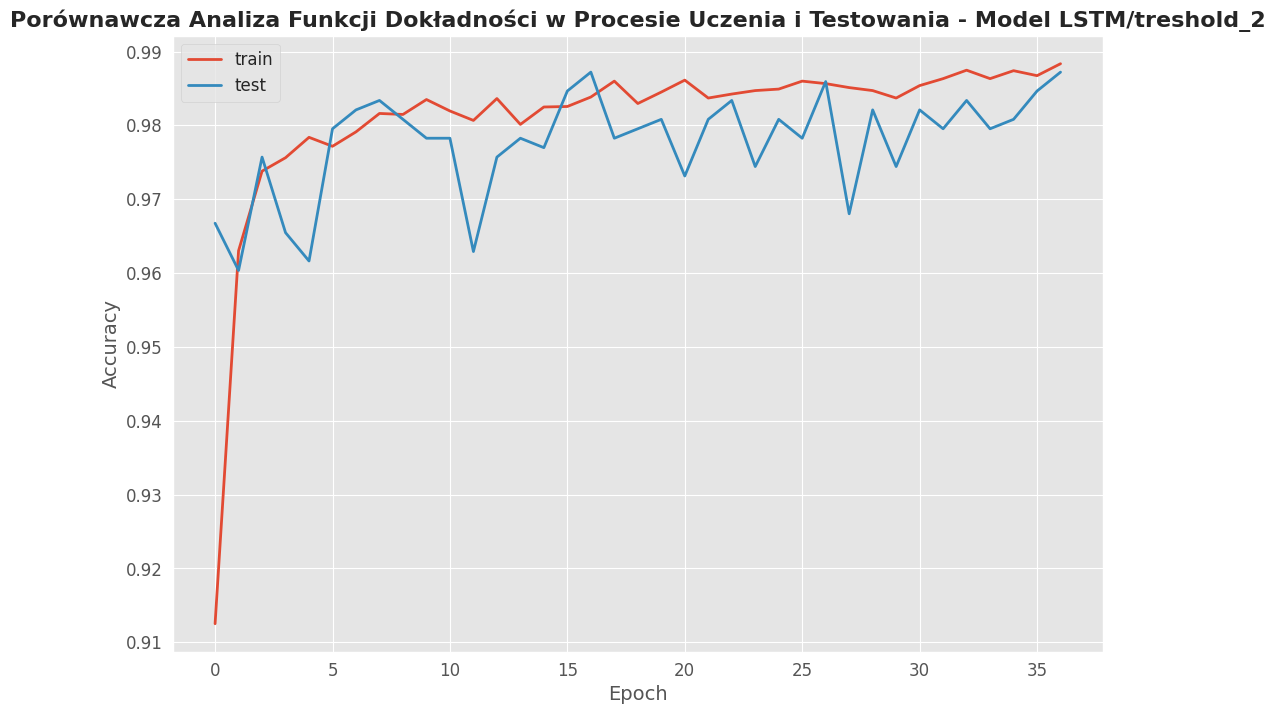

In [ ]:
# 4. Ewaluacja modelu na danych treningowych

# Porównawcza Analiza Funkcji Dokładności w Procesie Uczenia i Testowania
plt.style.use('ggplot')
fig_acc, ax = plt.subplots(figsize=(12, 8))
ax.plot(LSTM_model_2_history.history['accuracy'], label='train', linewidth=2)
ax.plot(LSTM_model_2_history.history['val_accuracy'], label='test', linewidth=2)
ax.set_title('Porównawcza Analiza Funkcji Dokładności w Procesie Uczenia i Testowania - Model LSTM/treshold_2', fontsize=16, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='upper left', fontsize=12)
ax.grid(True)
plt.show()
fig_acc.savefig("/content/drive/MyDrive/RUL_model/LSTM_model_2_history_accuracy.png")

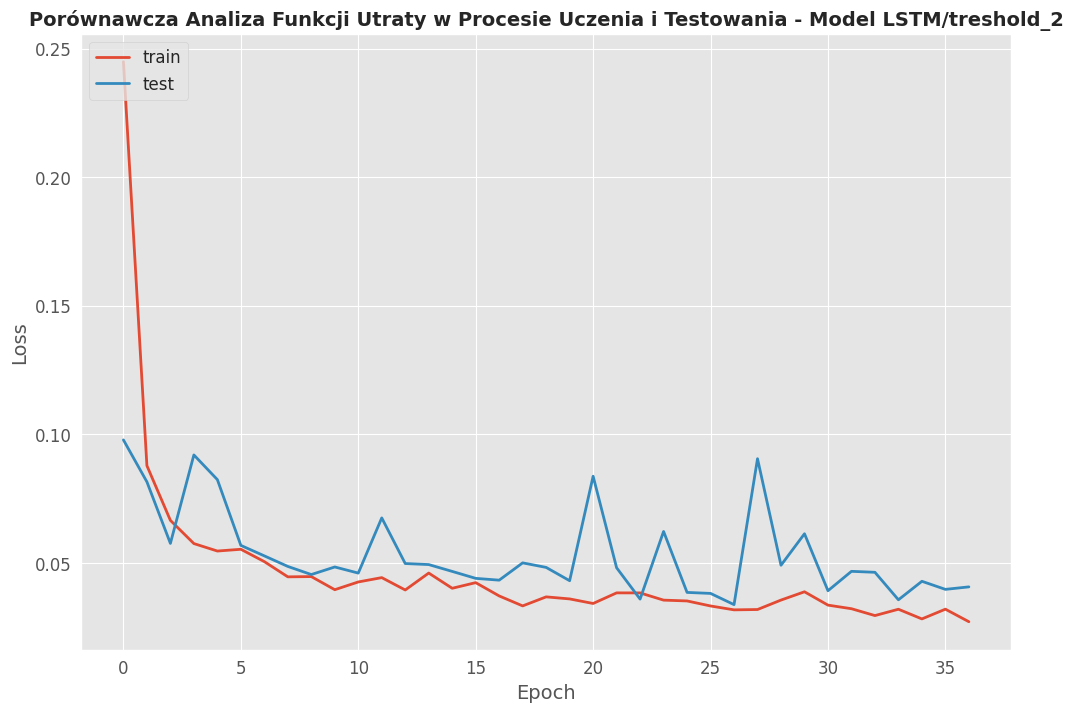

In [ ]:
# Porównawcza Analiza Funkcji Utraty w Procesie Uczenia i Testowania
plt.style.use('ggplot')
fig_loss, ax = plt.subplots(figsize=(12, 8))
ax.plot(LSTM_model_2_history.history['loss'], label='train', linewidth=2)
ax.plot(LSTM_model_2_history.history['val_loss'], label='test', linewidth=2)
ax.set_title('Porównawcza Analiza Funkcji Utraty w Procesie Uczenia i Testowania - Model LSTM/treshold_2', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='upper left', fontsize=12)
ax.grid(True)
plt.show()
fig_loss.savefig("/content/drive/MyDrive/RUL_model/LSTM_model_2_history_loss.png")

In [ ]:
# make predictions
LSTM_model_2_y_pred = np.argmax(LSTM_model_2.predict(sequence_array,verbose=1, batch_size=200), axis=-1)
LSTM_model_2_y_true = np.argmax(labels_array_threshold_2, axis=-1)

79/79 [==============================] - 1s 5ms/step


In [ ]:
# Obliczenie metryk
accuracy = accuracy_score(LSTM_model_2_y_true, LSTM_model_2_y_pred)
precision = precision_score(LSTM_model_2_y_true, LSTM_model_2_y_pred, average='macro')
recall = recall_score(LSTM_model_2_y_true, LSTM_model_2_y_pred, average='macro')
f1 = f1_score(LSTM_model_2_y_true, LSTM_model_2_y_pred, average='macro')

# Utworzenie DataFrame
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
})
metrics

,Metric,Value
0,Accuracy,0.987845
1,Precision,0.962083
2,Recall,0.988152
3,F1 Score,0.974592


In [ ]:
# Rysowanie krzywej ROC
# One-vs-Rest multiclass ROC
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

auc_roc = multiclass_roc_auc_score(LSTM_model_2_y_true, LSTM_model_2_y_pred)
print('AUC ROC:', auc_roc)

AUC ROC: 0.9881516517626191


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


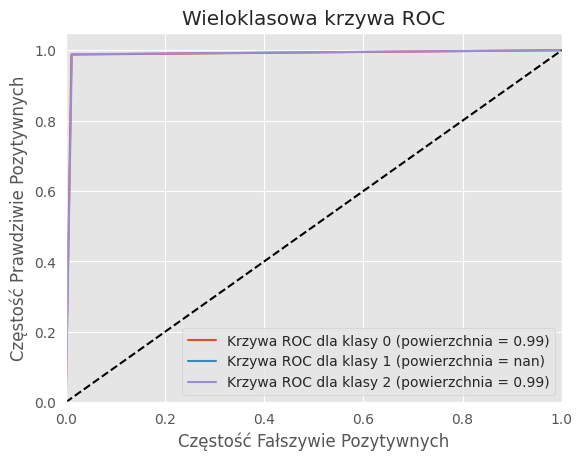

In [ ]:
# Binarize the output
y_true_bin = label_binarize(LSTM_model_2_y_true, classes=[0, 1, 2])
y_pred_bin = label_binarize(LSTM_model_2_y_pred, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# Obliczanie krzywej ROC i AUC dla każdej klasy
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Rysowanie krzywych ROC dla wszystkich klas
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Krzywa ROC dla klasy {0} (powierzchnia = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Częstość Fałszywie Pozytywnych')
plt.ylabel('Częstość Prawdziwie Pozytywnych')
plt.title('Wieloklasowa krzywa ROC')
plt.legend(loc="lower right")
plt.show()

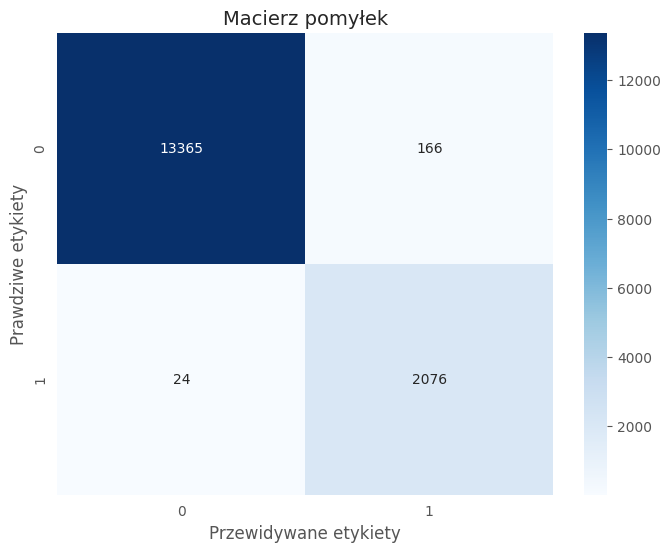

In [ ]:
# Obliczanie macierzy pomyłek
cm = confusion_matrix(LSTM_model_2_y_true, LSTM_model_2_y_pred)

plt.figure(figsize=(8, 6))

# Utworzenie heatmapy za pomocą seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Macierz pomyłek', fontsize=14)
plt.ylabel('Prawdziwe etykiety', fontsize=12)
plt.xlabel('Przewidywane etykiety', fontsize=12)
plt.show()


In [ ]:
# 4. Ewaluacja modelu na danych testowych

sequence_data_test = [FD001_test[FD001_test['engine_number']==id][sequence_variable].values[-sequence_size:]
                       for id in FD001_test['engine_number'].unique() if len(FD001_test[FD001_test['engine_number']==id]) >= sequence_size]
sequence_array_test = np.asarray(sequence_data_test).astype(np.float32)

# Pobierania etykiet sekwencji, które mają co najmniej 50 elementów
more_50 = [len(FD001_test[FD001_test['engine_number']==id]) >= sequence_size for id in FD001_test['engine_number'].unique()]
label_array_test_treshold_2 = FD001_test.groupby('engine_number')['threshold_2'].nth(-1)[more_50].values
label_array_test_treshold_2 = label_array_test_treshold_2.reshape(label_array_test_treshold_2.shape[0],1).astype(np.float32)
labels_array_test_treshhold_2 = to_categorical(label_array_test_treshold_2)
print(sequence_array_test.shape)
print(label_array_test_treshold_2.shape)


(93, 50, 18)
(93, 1)


In [ ]:
# make predictions
LSTM_model_2_y_pred = np.argmax(LSTM_model_2.predict(sequence_array_test,verbose=1, batch_size=200), axis=-1)
LSTM_model_2_y_true = np.argmax(labels_array_test_treshhold_2, axis=-1)

1/1 [==============================] - 0s 20ms/step


In [ ]:
# Obliczenie metryk
accuracy = accuracy_score(LSTM_model_2_y_true, LSTM_model_2_y_pred)
precision = precision_score(LSTM_model_2_y_true, LSTM_model_2_y_pred, average='macro')
recall = recall_score(LSTM_model_2_y_true, LSTM_model_2_y_pred, average='macro')
f1 = f1_score(LSTM_model_2_y_true, LSTM_model_2_y_pred, average='macro')

# Utworzenie DataFrame
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
})

metrics

,Metric,Value
0,Accuracy,0.967742
1,Precision,0.934598
2,Recall,0.955763
3,F1 Score,0.944742


In [ ]:
#One-vs-Rest multiclass ROC
#Żródło: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

auc_roc = multiclass_roc_auc_score(LSTM_model_2_y_true, LSTM_model_2_y_pred)
print('AUC ROC:', auc_roc)

AUC ROC: 0.955762987012987


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


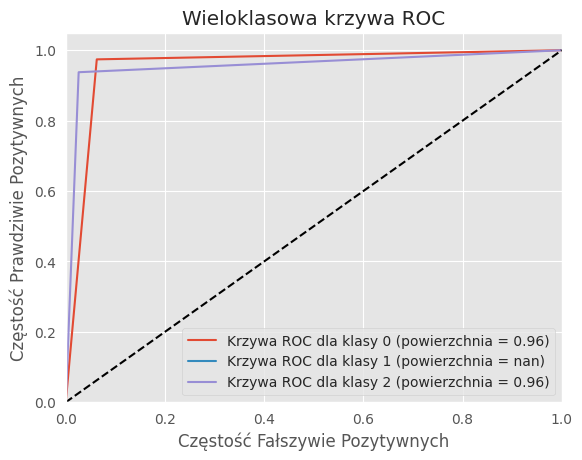

<Figure size 640x480 with 0 Axes>

In [ ]:
# Binarize the output
y_true_bin = label_binarize(LSTM_model_2_y_true, classes=[0, 1, 2])
y_pred_bin = label_binarize(LSTM_model_2_y_pred, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# Obliczanie krzywej ROC i AUC dla każdej klasy
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Rysowanie krzywych ROC dla wszystkich klas
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Krzywa ROC dla klasy {0} (powierzchnia = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Częstość Fałszywie Pozytywnych')
plt.ylabel('Częstość Prawdziwie Pozytywnych')
plt.title('Wieloklasowa krzywa ROC')
plt.legend(loc="lower right")
plt.show()
plt.savefig('/content/drive/MyDrive/RUL_model/LSTM_model_treshold_2_wieloklasowa_ROC_test.png')

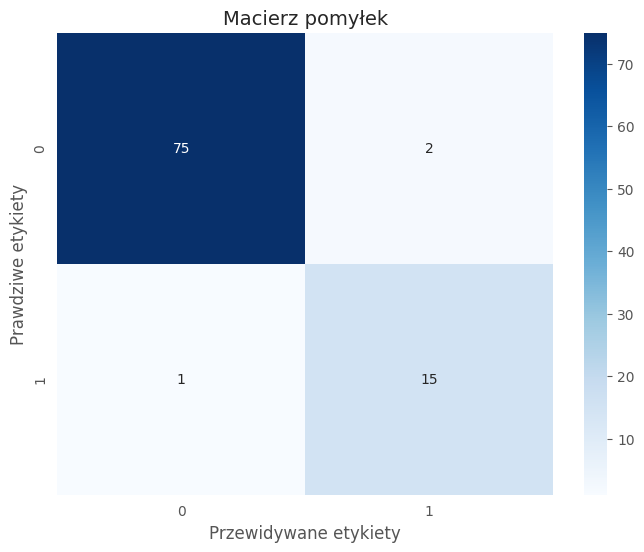

In [ ]:
# Obliczanie macierzy pomyłek
cm = confusion_matrix(LSTM_model_2_y_true, LSTM_model_2_y_pred)

plt.figure(figsize=(8, 6))

# Utworzenie heatmapy za pomocą seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Macierz pomyłek', fontsize=14)
plt.ylabel('Prawdziwe etykiety', fontsize=12)
plt.xlabel('Przewidywane etykiety', fontsize=12)
plt.savefig("/content/drive/MyDrive/RUL_model/LSTM_model_treshold_2_macierz_pomylek_test.png")
plt.show()

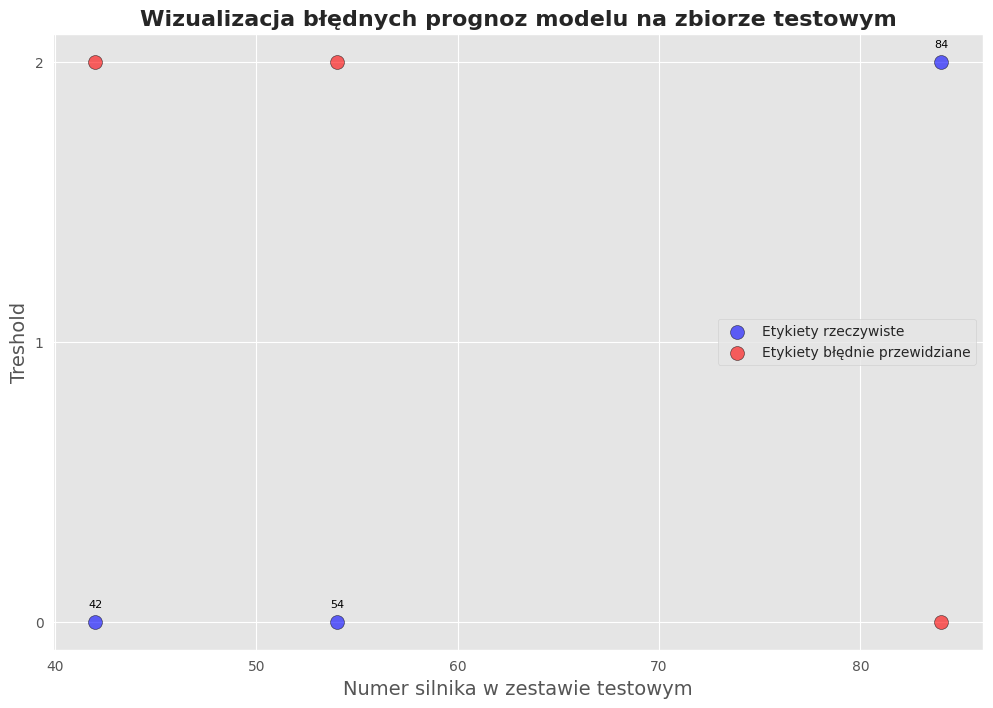

In [ ]:
# Wyciągnięcie numerów indeksów, gdzie model dokonał złej predykcji
plt.style.use('ggplot')
incorrect_pred_index = np.where(LSTM_model_2_y_true != LSTM_model_2_y_pred)[0]
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(incorrect_pred_index, LSTM_model_2_y_true[incorrect_pred_index], color="blue", edgecolors='k', s=100, alpha=0.6, label="Etykiety rzeczywiste")
ax.scatter(incorrect_pred_index, LSTM_model_2_y_pred[incorrect_pred_index], color="red", edgecolors='k', s=100, alpha=0.6, label="Etykiety błędnie przewidziane")

ax.set_title('Wizualizacja błędnych prognoz modelu na zbiorze testowym', fontsize=16, fontweight='bold')
ax.set_xlabel('Numer silnika w zestawie testowym', fontsize=14)
ax.set_ylabel('Treshold', fontsize=14)

ax.legend()

# Ustawiam tylko wybrane wartości na osi y
ax.set_yticks([0, 1, 2])

# Dodaje etykiety do punktów danych
for i in incorrect_pred_index:
    ax.annotate(i, (i, LSTM_model_2_y_true[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color="black")

plt.savefig("/content/drive/MyDrive/RUL_model/LSTM_model_treshold_2_wizualizacja_prognoz_test.png")
plt.show()

# Model LSTM_ regresja RUL